
<span style='font-family: Times; font-size: 2em;'># MIMIC v. 2.2 database exploratory data analysis</span>

**Veronica Ramirez-Lopera** 


### Objectives: 

1. Data Profiling and Familiarization
1. Data quality assessment
1. Trend Identification and Analysis
1. test and training group selection
1. Group Validation
1. Hypothesis Formulation and Conclusions 
1. Deep learning Model Creation 


### **Table of contents**

- [Introduction](#introduction)
- [Package Requirements](#package_requirements)
- [Data importing](#importing)
- [Understanding the data](#understanding) 
- [Summarizing the data](#summary) 
    - [Univariate Analysis](#uni) 
    - [Data cleaning](#clean) 
    - [Multivariate analysis](#multi)
- [Automatic profiling](#auto)
- [Deep learning model creation, raw data upload and feature engineering](#raw)
- [References](#ref)

## Introduction <a name='introduction'></a>

MIMIC-IV is a freely available electronic health record (EHR) dataset encompassing a decade of patient information (2008-2019) from Beth Israel Deaconess Medical Center [1]. It surpasses its predecessor, MIMIC-III, with a better structure and additional patient information [2, 3].

The dataset draws upon two primary sources: a comprehensive hospital-wide EHR system and an ICU-specific clinical information system [1]. Rigorous de-identification procedures ensure patient privacy while preserving the data's scientific integrity.

It includes vital signs, diagnoses, medications, procedures, and de-identified clinical notes [1]. Researchers leverage MIMIC-IV to investigate disease progression, train machine learning models, and develop clinical decision support tools [1, 2].

As a result, null dates of death indicate the patient was alive at least up to that time point. Inferences regarding patient death beyond one year cannot be made using MIMIC-IV (as per the PhyioNet website) [2]. The majority of patient death information is acquired from hospital records when the individual dies within the BIDMC or an affiliated institute.

MIMIC-IV also offers a dedicated module: MIMIC-IV ECG. This subset focuses specifically on diagnostic electrocardiograms (ECGs) [2]. It includes approximately 800,000 10-second ECG recordings from nearly 160,000 unique patients. Each ECG utilizes 12 leads and is sampled at 500 Hz [3].


## Package requirements <a name='package_requirements'></a>

Notes!: 

1- You need to install gcloud if you haven't already

2- I understand there are more direct methods to query the SQL database and consolidate all information into a single dataframe using subqueries, inner joins, and left joins. However, my attempts revealed that my current computational resources are insufficient for this approach. Therefore, I will generate individual dataframes and merge them subsequently


In [1]:

from google.cloud import bigquery
import pandas as pd
import missingno as msno
import wfdb
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import numpy as np
import zipfile
import io
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import signal


# Formatting for my pandas dataframes, ignore:

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None) 

# Construct a BigQuery client
client = bigquery.Client()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6272\2009793208.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Let's generate the initial table from the hospital folder. This table includes patient demographic data and hospitalization details. For this analysis, I will exclude the intra-hospital transfers information. 

Additionally, I will extract data from the icd_diagnoses table, which includes ICD-9 codes assigned to patients, and from lab_items.

In [2]:
# Query to fetch the patients table

query = """
SELECT
  subject_id,
  gender,
  anchor_age,
  anchor_year_group,
  dod
FROM 
  `physionet-data.mimiciv_hosp.patients`
LIMIT 100000
"""

# Fetch the data as a DataFrame
patients = client.query(query).to_dataframe(create_bqstorage_client=True)

# Fetch admissions data
admissions_query = """
SELECT
  subject_id,
  hadm_id,
  admittime,
  dischtime,
  admission_type,
  admission_location,
  discharge_location,
  language,
  race
FROM 
  `physionet-data.mimiciv_hosp.admissions`
LIMIT 100000
"""

# Fetch the admissions data as a DataFrame
admissions = client.query(admissions_query).to_dataframe(create_bqstorage_client=True)

# Display the first few rows of the DataFrames
print("Patients data:")
print(patients.head())

print("\nAdmissions data:")
print(admissions.head())

Patients data:
   subject_id gender  anchor_age anchor_year_group  dod
0    14178262      F          45       2020 - 2022  NaT
1    10180372      M          18       2008 - 2010  NaT
2    11092326      M          18       2008 - 2010  NaT
3    11776346      F          18       2008 - 2010  NaT
4    11818632      F          18       2008 - 2010  NaT

Admissions data:
   subject_id   hadm_id           admittime           dischtime  \
0    10106244  26713233 2147-05-09 10:34:00 2147-05-12 13:43:00   
1    13700703  20448599 2172-09-25 01:01:00 2172-10-03 13:25:00   
2    15443666  27961368 2168-12-30 23:30:00 2169-01-05 16:02:00   
3    16299919  26977065 2193-05-15 08:37:00 2193-05-17 16:03:00   
4    19596808  26675460 2128-06-04 16:13:00 2128-06-05 11:36:00   

      admission_type  admission_location discharge_location language  \
0       DIRECT EMER.  PHYSICIAN REFERRAL               HOME  ENGLISH   
1  OBSERVATION ADMIT      EMERGENCY ROOM               HOME  ENGLISH   
2  OBSERVATI

In [3]:
# Query the guide table for the lab items at d_labitems, and the lab events at labevents

lab_query = """
SELECT
  itemid,
  label,
  fluid
FROM
    `physionet-data.mimiciv_hosp.d_labitems`
"""

lab_events_query = """
SELECT
subject_id,
hadm_id,
itemid,
charttime AS lab_time,
valuenum,
valueuom,
flag AS abnormal_lab
FROM
    `physionet-data.mimiciv_hosp.labevents`
LIMIT 100000
"""

# Fetch the lab data as a DataFrame
lab_guide = client.query(lab_query).to_dataframe(create_bqstorage_client=True)
lab = client.query(lab_events_query).to_dataframe(create_bqstorage_client=True)

# Display the first few rows of the DataFrames
print("\nLab guide data:")
print(lab_guide.head())

print("\nLab events data:")
print(lab.head())



Lab guide data:
   itemid                   label  fluid
0   52038             Base Excess  Fluid
1   52039  Calculated Bicarbonate  Fluid
2   52040                    pCO2  Fluid
3   52041                      pH  Fluid
4   52042                     pO2  Fluid

Lab events data:
   subject_id   hadm_id  itemid            lab_time  valuenum valueuom  \
0    10000980  29659838   51282 2191-07-17 07:30:00      0.06     m/uL   
1    10001823      <NA>   51132 2150-09-14 10:35:00    921.00     #/uL   
2    10002930      <NA>   51131 2201-08-12 10:40:00    230.00     #/uL   
3    10003019  21616816   51802 2174-09-18 18:03:00     75.00    mg/dL   
4    10005808  26543907   51802 2119-01-02 17:11:00     72.00    mg/dL   

  abnormal_lab  
0         None  
1     abnormal  
2     abnormal  
3     abnormal  
4     abnormal  


In [4]:
# Lastly, we will extract the ICD-9 codes for the patients. This table contains the subject_id, hadm_id, icd9_code and seq_num.

icd_query_guide = """
SELECT
icd_code,
icd_version,
long_title
FROM
    `physionet-data.mimiciv_hosp.d_icd_diagnoses`
"""

icd_query = """
SELECT 
subject_id,
hadm_id,
icd_code,
icd_version
FROM
    `physionet-data.mimiciv_hosp.diagnoses_icd`
LIMIT 100000

"""
#Fetch the data as a DataFrame
icd_guide = client.query(icd_query_guide).to_dataframe(create_bqstorage_client=True)
icd = client.query(icd_query).to_dataframe(create_bqstorage_client=True)

# Display the first few rows of the DataFrames
print("\nICD guide data:")
print(icd_guide.head())

print("\nICD data:")
print(icd.head())



ICD guide data:
  icd_code  icd_version                             long_title
0     0010            9         Cholera due to vibrio cholerae
1     0011            9  Cholera due to vibrio cholerae el tor
2     0019            9                   Cholera, unspecified
3     0020            9                          Typhoid fever
4     0021            9                    Paratyphoid fever A

ICD data:
   subject_id   hadm_id icd_code  icd_version
0    10000935  26381316      311            9
1    10000935  26381316    78052            9
2    10000980  25242409    58381            9
3    10000980  25242409    44021            9
4    10000980  25242409    27800            9


Lastly, from the MIMCIV ecg folder, provided in https://physionet.org/content/mimic-iv-ecg/1.0/, we will extract some of the ecg file paths and reports. Keep in mind that the hea files that contain the metadata of the ecg, and the dat files that contain the actual ecg waveforms are not stored in BigQuery, so they must be downloaded and stored locally from the link provided. 

The record_list.csv file contains the file name and path for each WFDB record. It also provides the corresponding subject ID and study ID. The subject ID can be used to link a subject from MIMIC-IV-ECG to the other modules in the MIMIC-IV Clinical Database. 

Machine measurements for each ECG waveform are provided in the machine_measurements.csv file. A data dictionary provides a description for each of the columns in machine_measurements_data_dictionary.csv.  In addition to the summary measurements (rr_interval, qrs_onset, qrs_end, etc.) columns for the machine's bandwidth and filter settings (filtering) are provided. A cart_id is provided which can be used to track which machine was used for a given ECG. Finally, the subject_id, study_id, and ecg_time are provided, consistent with the ECG waveform files themselves. 



Waveform Notes:

There are over 600,000 cardiologist reports available for approximately 800,000 diagnostic ECGs. Not all diagnostic ECGs are interpreted by a cardiologist, which explains why there are fewer reports than waveforms.

The waveform_note_links.csv table associates a note_id with each ECG waveform. This note_id can link the waveform to the free-text note in the MIMIC-IV-Note module. Each note_id consists of the subject ID, the domain abbreviation (EK) indicating the source of the report, and a sequential integer (note_seq) that indicates the order of ECG collection for a subject across their visits. This table also includes the subject ID, study ID, and waveform path.

While these reports offer significant potential for machine learning models and data analysis studies, they have not been standardized yet. Currently, I am focusing on developing a model using the waveform data itself, so I will not be utilizing this free-text note data. 

In [5]:
# Lets query the ecg dataframe, in the records_list folder 

ecg_query = """
SELECT 
subject_id,
study_id,
file_name,
ecg_time,
path

FROM
    `physionet-data.mimiciv_ecg.record_list`
LIMIT 100000
"""

# Fetch the data as a DataFrame
ecg = client.query(ecg_query).to_dataframe(create_bqstorage_client=True)

# Display the first few rows of the DataFrames
print("\nECG data:")
print(ecg.head())


ECG data:
   subject_id  study_id file_name            ecg_time  \
0    10000032  40689238  40689238 2180-07-23 08:44:00   
1    10000032  44458630  44458630 2180-07-23 09:54:00   
2    10000032  49036311  49036311 2180-08-06 09:07:00   
3    10000117  45090959  45090959 2181-03-04 17:14:00   
4    10000117  48446569  48446569 2183-09-18 13:52:00   

                                       path  
0  files/p1000/p10000032/s40689238/40689238  
1  files/p1000/p10000032/s44458630/44458630  
2  files/p1000/p10000032/s49036311/49036311  
3  files/p1000/p10000117/s45090959/45090959  
4  files/p1000/p10000117/s48446569/48446569  



# Understanding/Cleaning the Data <a name='understanding'></a>

Now, lets take a look at our tables 

- patients: demographic data
- admissions: hospitalization data
- lab_guide: lab items guide
- lab: lab events
- icd_guide: ICD-9 codes guide
- icd: diagnoses ICD-9 codes
- ecg: EKG paths and subject info


Firstly, Lets merge the patients and admissions dataframes. We will use the subject_id as the key to merge the dataframes for our demographic and hospitalization data.

For this purpose, we will only be using the patients with hospital admissions! The database contains outpatient information too, so we must clear this data first.  


In [6]:
#Are any subjects in the patients table not in the admissions table?
patients_subjects = set(patients['subject_id'])

patients_not_in_admissions = patients_subjects - set(admissions['subject_id'])

print(f"Number of subjects in the patients table but not in the admissions table: {len(patients_not_in_admissions)}")

#Patients without admissions were collected as outpatients, and are not included in the admissions table. They are not relevant for this analysis, as acute stroke patients are unlikely to be admitted as outpatients so we will drop them.

patients = patients[patients['subject_id'].isin(admissions['subject_id'])]

#Are any subjects in the admissions table not in the patients table?

admissions_subjects = set(admissions['subject_id'])
admissions_not_in_patients = admissions_subjects - set(patients['subject_id'])

print(f"Number of subjects in the admissions table but not in the patients table: {len(admissions_not_in_patients)}")

Number of subjects in the patients table but not in the admissions table: 78852
Number of subjects in the admissions table but not in the patients table: 45243


In [7]:
#Are any patients repeated in the patients table?

repeated_patients = patients['subject_id'].value_counts().sort_values(ascending=False)

print(f"Number of repeated patients in the patients table: {len(repeated_patients[repeated_patients > 1])}")


Number of repeated patients in the patients table: 0


Next, for analysis purposes, we will add two other columns: 

- One with the patients length of stay 
- Another one with the mean year of the deidentified admission year interval 

In [8]:
print(patients.shape, admissions.shape, lab.shape, lab_guide.shape, icd.shape, ecg.shape)

demographic = pd.merge(patients, admissions, on='subject_id', how='inner')

#Lets add a column with the length of stay in days
demographic['length_of_stay'] = demographic['dischtime'] - demographic['admittime']

#Lets replace the year intervals with the mean year of the interval for the anchor_year_group column.

demographic['anchor_year_group'] = demographic['anchor_year_group'].str.extract(r'(\d{4}) - (\d{4})').astype(int).mean(axis=1)

demographic.head()

(21148, 5) (100000, 9) (100000, 7) (1622, 3) (100000, 4) (100000, 5)


,subject_id,gender,anchor_age,anchor_year_group,dod,hadm_id,admittime,dischtime,admission_type,admission_location,discharge_location,language,race,length_of_stay
0,11776346,F,18,2009.0,NaT,29730252,2110-09-16 03:10:00,2110-09-16 07:18:00,EU OBSERVATION,EMERGENCY ROOM,None,ENGLISH,ASIAN - ASIAN INDIAN,0 days 04:08:00
1,19684909,F,18,2009.0,NaT,20426589,2110-05-21 06:33:00,2110-05-21 11:51:00,EU OBSERVATION,EMERGENCY ROOM,None,ENGLISH,WHITE,0 days 05:18:00
2,10052990,M,19,2009.0,NaT,22881830,2110-09-09 15:23:00,2110-09-12 11:55:00,DIRECT EMER.,CLINIC REFERRAL,HOME,ENGLISH,MULTIPLE RACE/ETHNICITY,2 days 20:32:00
3,10660842,F,19,2009.0,NaT,29291361,2110-11-27 03:17:00,2110-11-27 09:24:00,EU OBSERVATION,EMERGENCY ROOM,None,ENGLISH,WHITE,0 days 06:07:00
4,12432968,F,19,2009.0,NaT,28096041,2110-11-14 15:47:00,2110-11-16 19:00:00,URGENT,PHYSICIAN REFERRAL,HOME,ENGLISH,OTHER,2 days 03:13:00


Now, lets add a label for the lab events and the icd codes:

In [9]:
# Lets label the lab events with the lab guide. Repeating the process for the icd codes and the icd guide.

lab_merged = pd.merge(lab, lab_guide, on='itemid', how='inner')

#Lets change the abnormal_lab column to FALSE if they dont have a flag, and TRUE if they do.

lab_merged['abnormal_lab'] = lab_merged['abnormal_lab'].apply(lambda x: True if x == 'abnormal' else False)

lab_merged.head()

,subject_id,hadm_id,itemid,lab_time,valuenum,valueuom,abnormal_lab,label,fluid
0,10000980,29659838,51282,2191-07-17 07:30:00,0.06,m/uL,False,"Reticulocyte Count, Absolute",Blood
1,10001823,<NA>,51132,2150-09-14 10:35:00,921.00,#/uL,True,Absolute CD8 Count,Blood
2,10002930,<NA>,51131,2201-08-12 10:40:00,230.00,#/uL,True,Absolute CD4 Count,Blood
3,10003019,21616816,51802,2174-09-18 18:03:00,75.00,mg/dL,True,"Total Protein, CSF",Cerebrospinal Fluid
4,10005808,26543907,51802,2119-01-02 17:11:00,72.00,mg/dL,True,"Total Protein, CSF",Cerebrospinal Fluid


In [10]:
# Lets merge the icd codes with the icd guide. They have to match both the icd code and the icd version.

icd_merged = pd.merge(icd, icd_guide, on=['icd_code', 'icd_version'], how='inner')

# Now lets drop the columns that are not needed for the analysis. We are dropping icd_version

icd_merged = icd_merged.drop(['icd_version'], axis=1)

icd_merged.head()

,subject_id,hadm_id,icd_code,long_title
0,10000935,26381316,311,"Depressive disorder, not elsewhere classified"
1,10000935,26381316,78052,"Insomnia, unspecified"
2,10000980,25242409,58381,"Nephritis and nephropathy, not specified as ac..."
3,10000980,25242409,44021,Atherosclerosis of native arteries of the extr...
4,10000980,25242409,27800,"Obesity, unspecified"


We ended up with 3 dataframes, one for the demographic data, one for the lab events, one for the icd codes and one for the ecg data.
Lets merge them all together in the common columns = hadm_id and subject_id

In [11]:
# Merge demographic and lab_merged
df1 = pd.merge(demographic, lab_merged, on=['subject_id', 'hadm_id'], how='inner')

# Merge the result with icd_merged
df2 = pd.merge(df1, icd_merged, on=['subject_id', 'hadm_id'], how='inner')

# Delete duplicate rows

df2 = df2.drop_duplicates( )

df2.head()


,subject_id,gender,anchor_age,anchor_year_group,dod,hadm_id,admittime,dischtime,admission_type,admission_location,discharge_location,language,race,length_of_stay,itemid,lab_time,valuenum,valueuom,abnormal_lab,label,fluid,icd_code,long_title
0,15446133,M,73,2009.0,NaT,26899817,2120-05-31 07:46:00,2120-06-03 17:30:00,EW EMER.,WALK-IN/SELF REFERRAL,REHAB,ENGLISH,WHITE,3 days 09:44:00,51613,2120-06-01 06:45:00,123.0,mg/dL,False,eAG,Blood,R471,Dysarthria and anarthria
1,15446133,M,73,2009.0,NaT,26899817,2120-05-31 07:46:00,2120-06-03 17:30:00,EW EMER.,WALK-IN/SELF REFERRAL,REHAB,ENGLISH,WHITE,3 days 09:44:00,51613,2120-06-01 06:45:00,123.0,mg/dL,False,eAG,Blood,H53452,"Other localized visual field defect, left eye"
2,15446133,M,73,2009.0,NaT,26899817,2120-05-31 07:46:00,2120-06-03 17:30:00,EW EMER.,WALK-IN/SELF REFERRAL,REHAB,ENGLISH,WHITE,3 days 09:44:00,51613,2120-06-01 06:45:00,123.0,mg/dL,False,eAG,Blood,R29810,Facial weakness
3,15446133,M,73,2009.0,NaT,26899817,2120-05-31 07:46:00,2120-06-03 17:30:00,EW EMER.,WALK-IN/SELF REFERRAL,REHAB,ENGLISH,WHITE,3 days 09:44:00,51613,2120-06-01 06:45:00,123.0,mg/dL,False,eAG,Blood,I480,Paroxysmal atrial fibrillation
4,15446133,M,73,2009.0,NaT,26899817,2120-05-31 07:46:00,2120-06-03 17:30:00,EW EMER.,WALK-IN/SELF REFERRAL,REHAB,ENGLISH,WHITE,3 days 09:44:00,51613,2120-06-01 06:45:00,123.0,mg/dL,False,eAG,Blood,Z7901,Long term (current) use of anticoagulants


NOTE: There are up to 39 diagnoses billed per patient. While this might create the appearance of duplicates, each diagnosis is unique.

Let's proceed by merging the ECG data with the df2 dataframe, ensuring that we drop any empty rows since we need every patient to have an ECG record. We will focus only on patients with an ECG record, matching these records with the patients' hospitalization periods. Given that a patient can have multiple EKG records, we will use the 'ecg_time' column to align these records as per the MIMIC ECG database instructions, but I will use my own code to accomplish this.

In [12]:
# Define a function to match the ECG records for each row in df2, as instructed by the authors

def ecg_match(row):
    subject_id = row['subject_id']
    admittime = row['admittime']
    dischtime = row['dischtime']
    
    # Filter ECG records for the subject_id and within the hospitalization period
    filtered_ecg = ecg[(ecg['subject_id'] == subject_id) & 
                       (ecg['ecg_time'] >= admittime) & 
                       (ecg['ecg_time'] <= dischtime)]
    
    # Return paths as a list if there are any matches
    if not filtered_ecg.empty:
        sorted_ecg = filtered_ecg.sort_values(by='ecg_time')
        first_ecg = sorted_ecg.iloc[0]
        return first_ecg['path']
    else:
        return None

# Apply the function to each row of df2 and store results in 'path' column
df2['path'] = df2.apply(ecg_match, axis=1)

final_table = df2.dropna(subset=['path'])

# Check the results
print(final_table.head())


     subject_id gender  anchor_age  anchor_year_group         dod   hadm_id  \
160    10942537      M          64             2009.0  2120-12-19  23159420   
161    10942537      M          64             2009.0  2120-12-19  23159420   
162    10942537      M          64             2009.0  2120-12-19  23159420   
163    10942537      M          64             2009.0  2120-12-19  23159420   
164    10942537      M          64             2009.0  2120-12-19  23159420   

              admittime           dischtime admission_type admission_location  \
160 2120-01-31 16:19:00 2120-02-20 20:29:00       EW EMER.     EMERGENCY ROOM   
161 2120-01-31 16:19:00 2120-02-20 20:29:00       EW EMER.     EMERGENCY ROOM   
162 2120-01-31 16:19:00 2120-02-20 20:29:00       EW EMER.     EMERGENCY ROOM   
163 2120-01-31 16:19:00 2120-02-20 20:29:00       EW EMER.     EMERGENCY ROOM   
164 2120-01-31 16:19:00 2120-02-20 20:29:00       EW EMER.     EMERGENCY ROOM   

    discharge_location language   race

In [13]:
#Lets calculate the number of hospitalizations per patient. Lets count the number of different hadm_id for each subject_id and add it as a new column to the final_table.

hospitalizations = final_table.groupby('subject_id')['hadm_id'].nunique()

final_table['num_hospitalizations'] = final_table['subject_id'].map(hospitalizations)

final_table[['anchor_age', 'length_of_stay', 'num_hospitalizations']].describe()



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6272\2830219601.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table['num_hospitalizations'] = final_table['subject_id'].map(hospitalizations)


,anchor_age,length_of_stay,num_hospitalizations
count,1002.0,1002,1002.000000
mean,65.329341,29 days 17:21:11.856287,1.028942
std,11.863919,18 days 23:42:38.520775,0.167728
min,29.0,2 days 05:50:00,1.000000
25%,57.0,14 days 20:09:00,1.000000
50%,64.0,25 days 12:17:00,1.000000
75%,70.75,37 days 20:59:00,1.000000
max,91.0,206 days 10:13:00,2.000000


Perfect! Now that we have our full, merged table with all the necessary columns for the analysis, lets start with the observations. 

In [14]:
# Lets see if every assigned class for each column to see if the data type is correct, and the number of registries for each class.  

ecg_subset = ecg[['study_id', 'file_name', 'path']]

final_table = final_table.merge( ecg_subset, on='path', how='inner')

print(final_table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   subject_id            1002 non-null   Int64          
 1   gender                1002 non-null   object         
 2   anchor_age            1002 non-null   Int64          
 3   anchor_year_group     1002 non-null   float64        
 4   dod                   626 non-null    dbdate         
 5   hadm_id               1002 non-null   Int64          
 6   admittime             1002 non-null   datetime64[us] 
 7   dischtime             1002 non-null   datetime64[us] 
 8   admission_type        1002 non-null   object         
 9   admission_location    1002 non-null   object         
 10  discharge_location    1002 non-null   object         
 11  language              1002 non-null   object         
 12  race                  1002 non-null   object         
 13  len

All the types are correct, now lets handle the missing values and draw conclusions . 

In [15]:
# Lets identify and visualize the missing data for each dataframe.

print(final_table.isnull().sum())

subject_id                0
gender                    0
anchor_age                0
anchor_year_group         0
dod                     376
hadm_id                   0
admittime                 0
dischtime                 0
admission_type            0
admission_location        0
discharge_location        0
language                  0
race                      0
length_of_stay            0
itemid                    0
lab_time                  0
valuenum                  6
valueuom                  0
abnormal_lab              0
label                     0
fluid                     0
icd_code                  0
long_title                0
path                      0
num_hospitalizations      0
study_id                  0
file_name                 0
dtype: int64


Axes(0.125,0.11;0.698618x0.77)


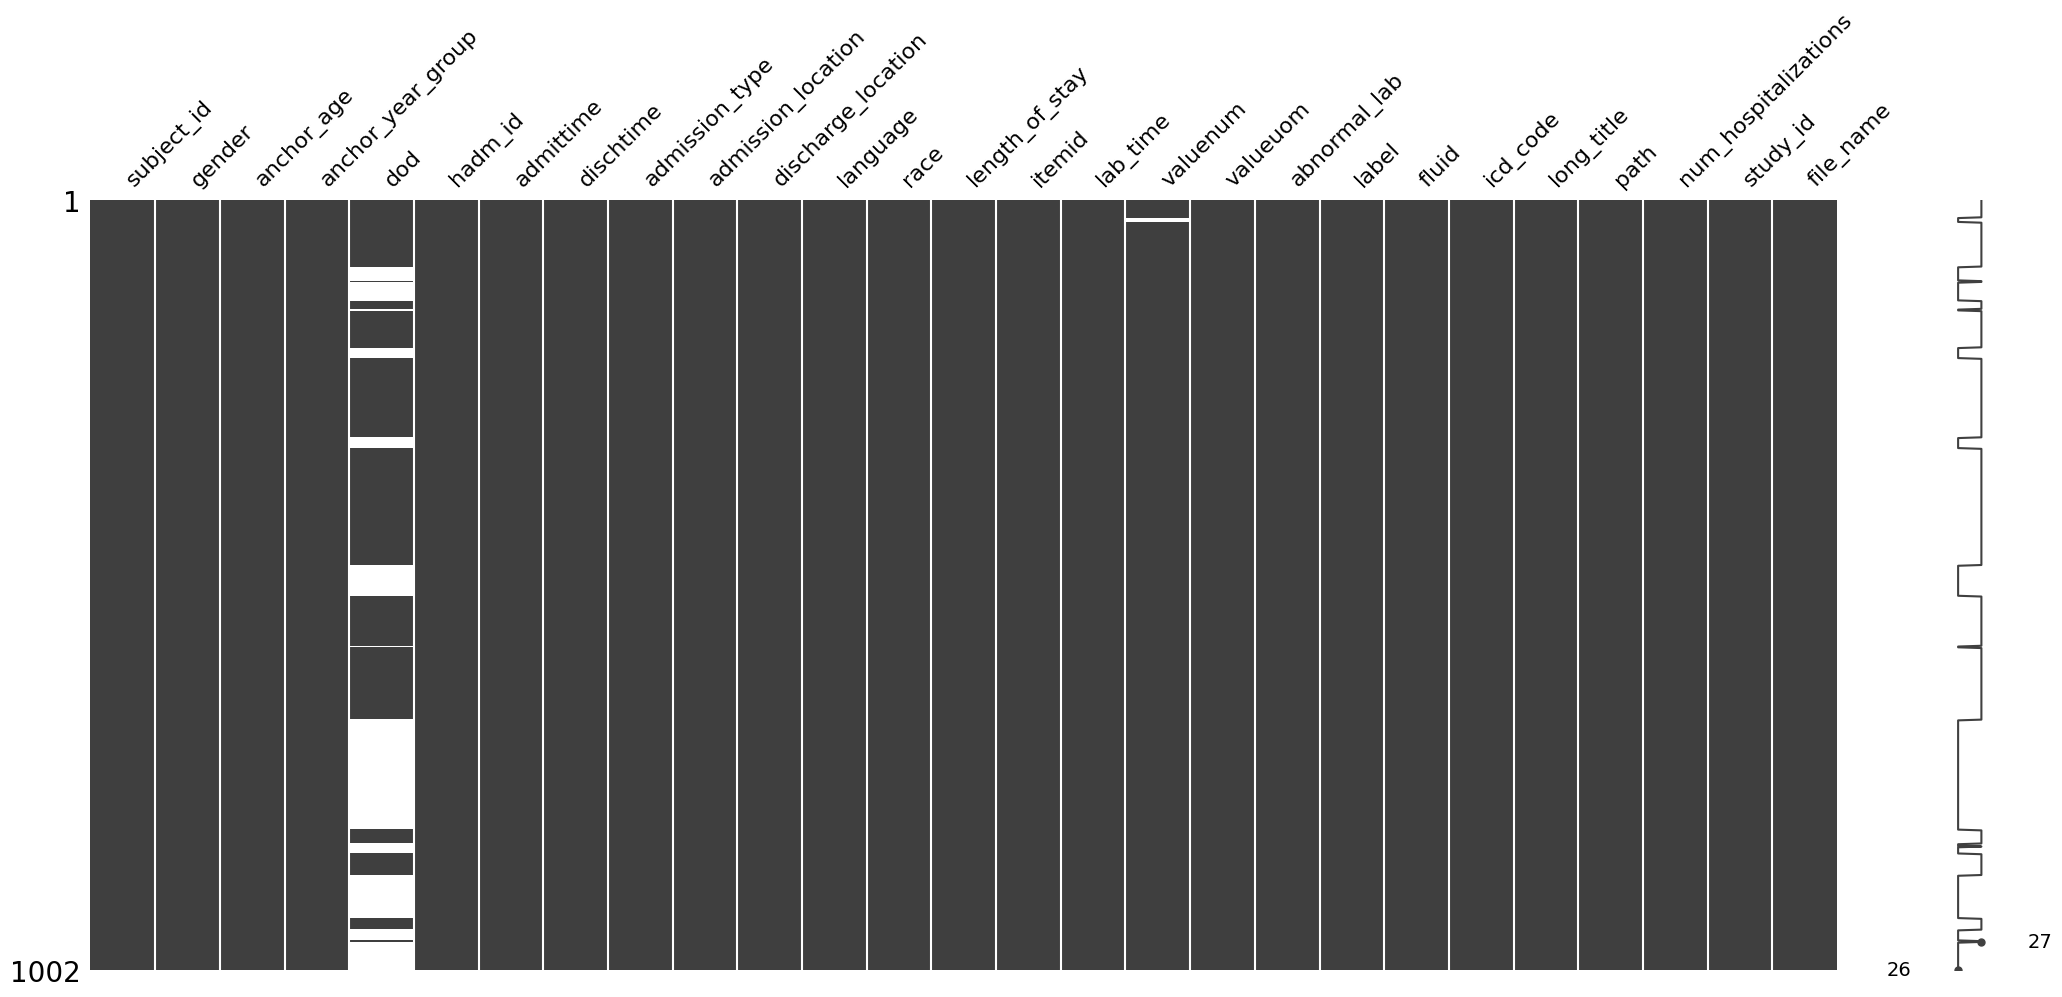

In [16]:
print(msno.matrix(final_table))

As we can see, there are multiple missing values in the DOD and the value_num of the dataframe. 
All the null values in the dod mean that the patient did not pass away in the subsequent 3 years after admission, so it is normal.

The null values in value_num do not have any real justification, they were probably due to human error while indexing data, therefore, we will drop those. 

** I am currently working with an incomplete dataset in this version of the code. Once I start using the virtual machine, the analysis will be complete 

In [17]:
#There are a lot of missing values in the value_num column in the dataframe. Lets drop the rows with missing values.

final_table.dropna(subset=['valuenum'], inplace=True)
final_table.head()

final_table_copy = final_table.copy()

# Univariate analysis <a name='Univariate'></a>

Quantitative:

Lets start by analyzing the demographic data.

Note: The analysis will be complete once I start working with the virtual machine. 

In [18]:
# Convert Timedelta to days for length_of_stay ** I was havig problemswith the describe function, so I converted the timedelta to days.
final_table["length_of_stay"] = final_table["length_of_stay"].dt.total_seconds() / (24 * 3600)

# Convert the remaining columns to numeric
final_table["anchor_age"] = pd.to_numeric(final_table["anchor_age"], errors='coerce')
final_table["num_hospitalizations"] = pd.to_numeric(final_table["num_hospitalizations"], errors='coerce')


# Describe the numerical columns
print(final_table[["anchor_age", "length_of_stay", "num_hospitalizations"]].describe())


       anchor_age  length_of_stay  num_hospitalizations
count       996.0      996.000000            996.000000
mean    65.337349       29.619859              1.023092
std     11.899185       18.998316              0.150272
min          29.0        2.243056              1.000000
25%          57.0       14.839583              1.000000
50%          64.0       25.511806              1.000000
75%          71.0       37.874306              1.000000
max          91.0      206.425694              2.000000



The mean age of the patients is 65.5 years, with a standard deviation of 16.5 years. The average length of stay is 9.5 days, with a standard deviation of 9.5 days. The average number of hospitalizations is 1.5, with a standard deviation of 1.1.

This snippet of the population indicates an elderly demographic with a relatively low number of hospitalizations. Since ischemic strokes are more prevalent in older adults, this data might overrepresent the population at risk for this condition.

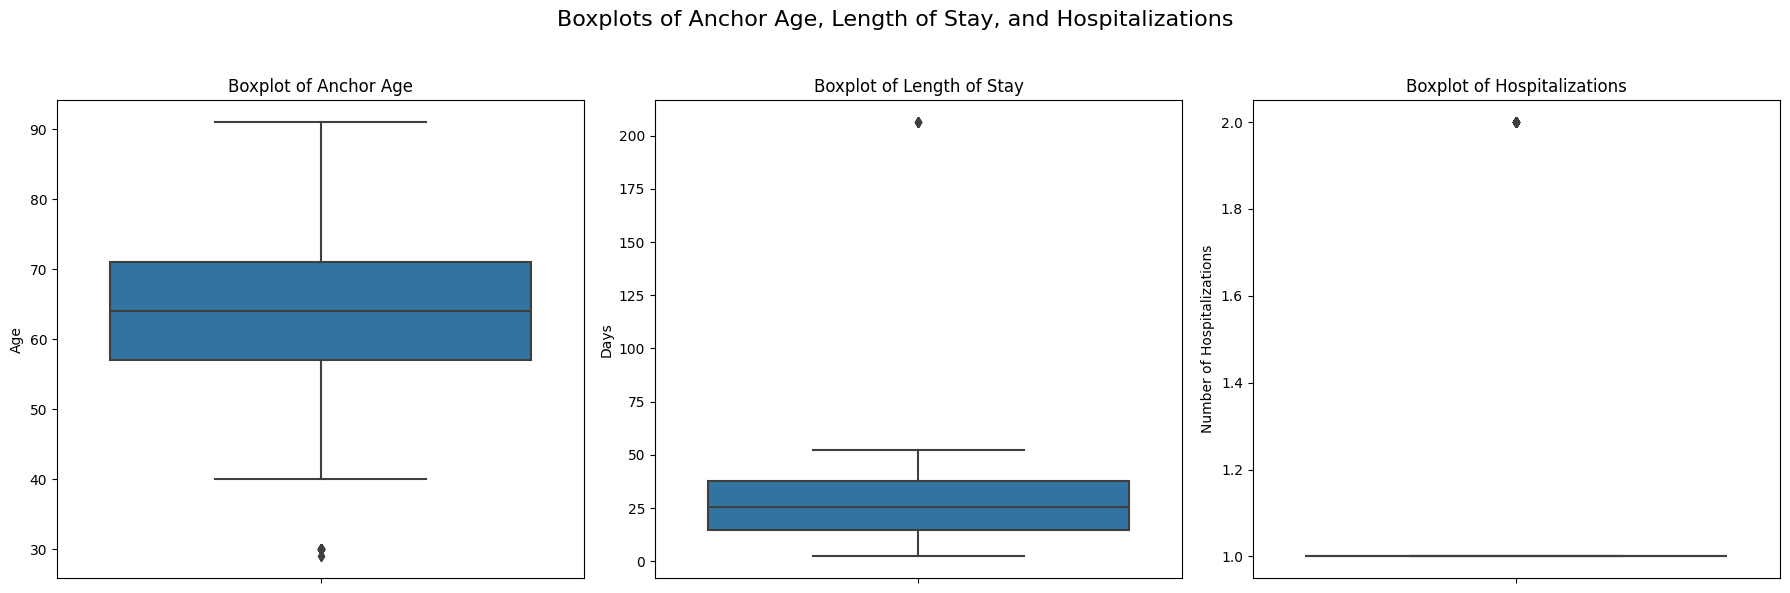

In [19]:
#Lets plot our quantitative variables to see their distribution in boxplots. anchor_age, length_of_stay and hospitalizations 

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the boxplot for anchor_age
sns.boxplot(y=final_table['anchor_age'], ax=axes[0])
axes[0].set_title('Boxplot of Anchor Age')
axes[0].set_ylabel('Age')

# Plot the boxplot for length_of_stay
sns.boxplot(y=final_table['length_of_stay'], ax=axes[1])
axes[1].set_title('Boxplot of Length of Stay')
axes[1].set_ylabel('Days')

# Plot the boxplot for hospitalizations
sns.boxplot(y=final_table['num_hospitalizations'], ax=axes[2])
axes[2].set_title('Boxplot of Hospitalizations')
axes[2].set_ylabel('Number of Hospitalizations')

# Add a main title for the entire figure
plt.suptitle('Boxplots of Anchor Age, Length of Stay, and Hospitalizations', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()


*Due to the small sample size there are not a lot patients with more than one hospitalization. This will likely change when we get a bigger sample size 

Now, lets get rid of the outliers using the interquartile method.  Then we will plot the results 

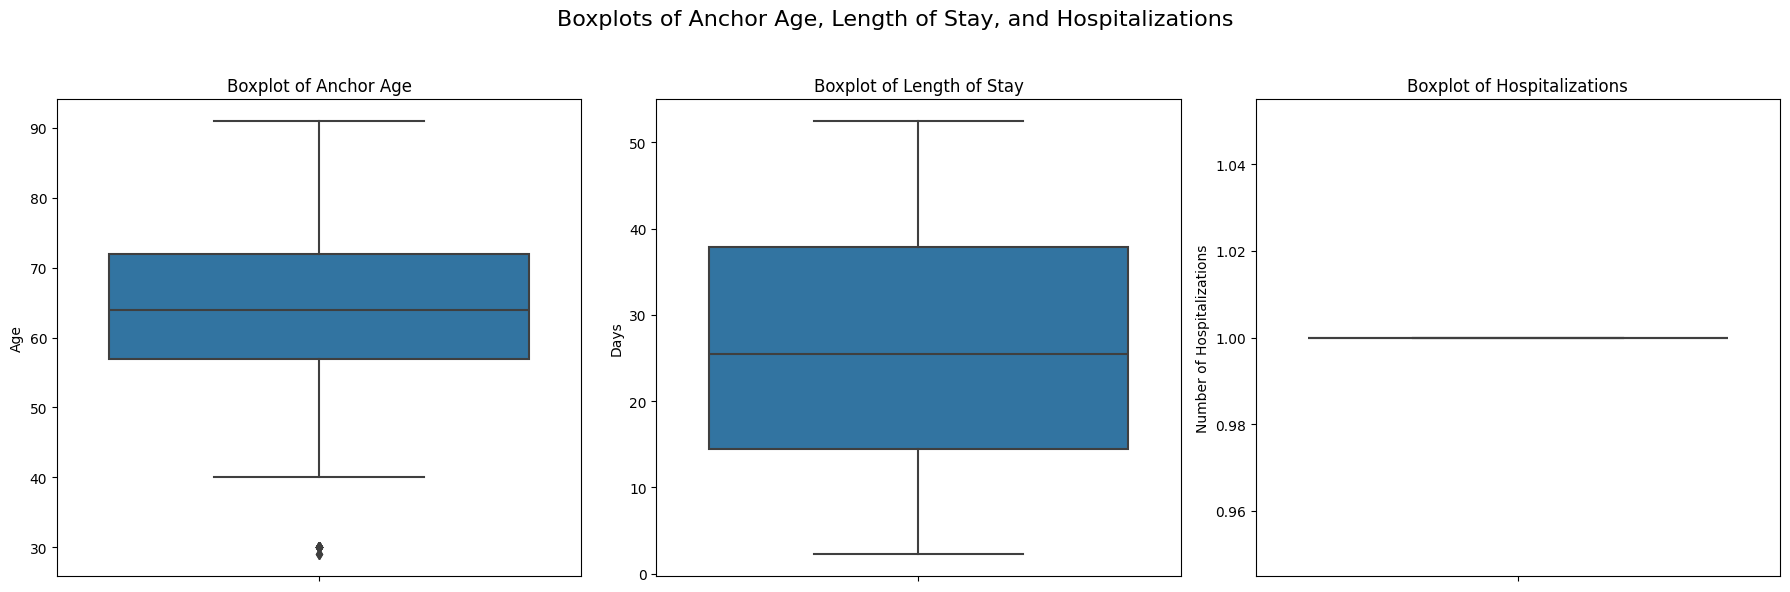

In [20]:

# Calculate the first and third quartiles for anchor_age
Q1 = final_table['length_of_stay'].quantile(0.25)
Q3 = final_table['length_of_stay'].quantile(0.75)

# Calculate the IQR for anchor_age
IQR = Q3 - Q1

# Define the lower and upper bounds for anchor_age
lower_bound_age = Q1 - 1.5 * IQR
upper_bound_age = Q3 + 1.5 * IQR

# Filter the rows with anchor_age within the bounds
final_table = final_table[(final_table['length_of_stay'] >= lower_bound_age) & (final_table['length_of_stay'] <= upper_bound_age)]

# Calculate the first and third quartiles for num_hospitalizations
Q1_hosp = final_table['num_hospitalizations'].quantile(0.25)
Q3_hosp = final_table['num_hospitalizations'].quantile(0.75)

# Calculate the IQR for hospitalization_count
IQR_hosp = Q3_hosp - Q1_hosp

# Define the lower and upper bounds for hospitalization_count
lower_bound_hosp = Q1_hosp - 1.5 * IQR_hosp
upper_bound_hosp = Q3_hosp + 1.5 * IQR_hosp

# Filter the rows with hospitalization_count within the bounds
final_table = final_table[(final_table['num_hospitalizations'] >= lower_bound_hosp) & (final_table['num_hospitalizations'] <= upper_bound_hosp)]

# Visualize the boxplots again

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the boxplot for anchor_age
sns.boxplot(y=final_table['anchor_age'], ax=axes[0])
axes[0].set_title('Boxplot of Anchor Age')
axes[0].set_ylabel('Age')

# Plot the boxplot for length_of_stay
sns.boxplot(y=final_table['length_of_stay'], ax=axes[1])
axes[1].set_title('Boxplot of Length of Stay')
axes[1].set_ylabel('Days')

# Plot the boxplot for hospitalizations
sns.boxplot(y=final_table['num_hospitalizations'], ax=axes[2])
axes[2].set_title('Boxplot of Hospitalizations')
axes[2].set_ylabel('Number of Hospitalizations')

# Add a main title for the entire figure
plt.suptitle('Boxplots of Anchor Age, Length of Stay, and Hospitalizations', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


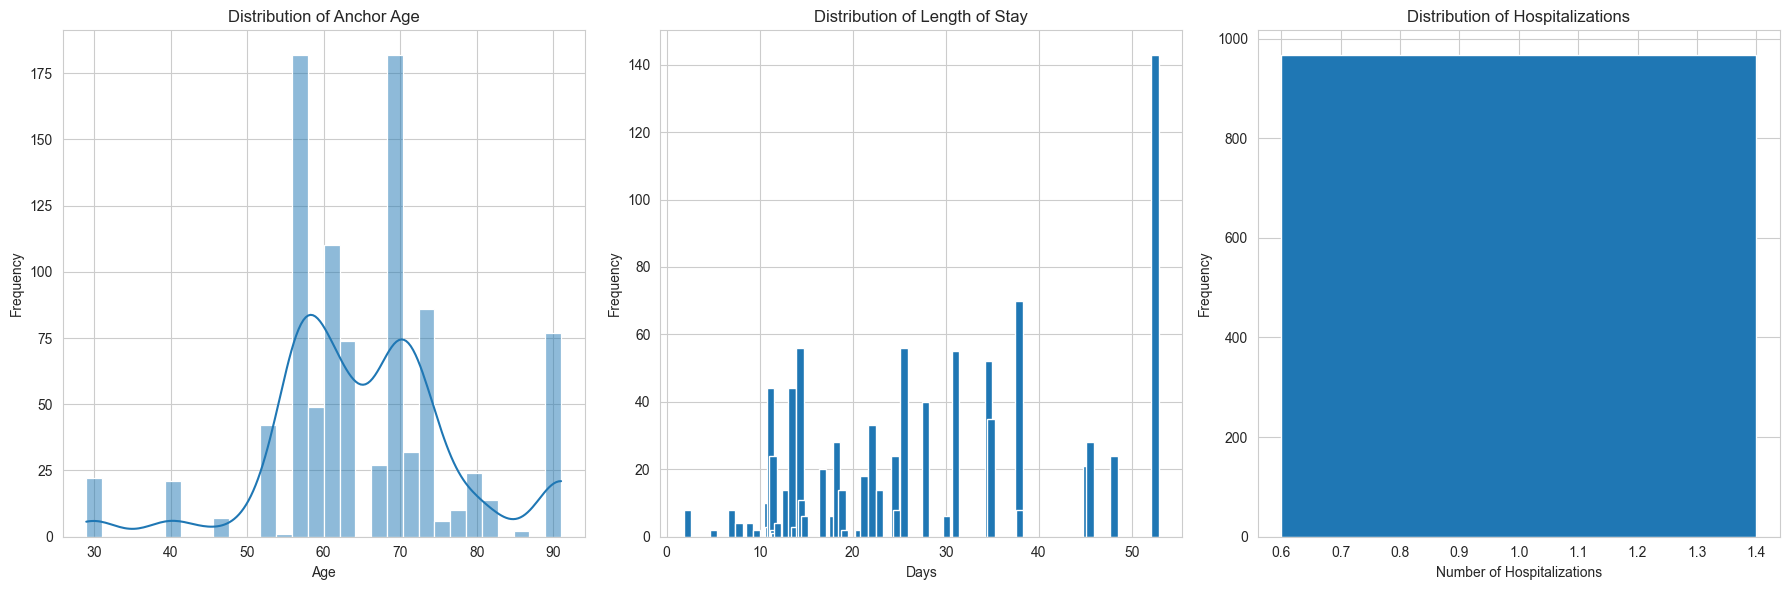

In [21]:
# Data distribution

# Set the style of the plots
sns.set_style("whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution of the anchor_age variable
sns.histplot(final_table['anchor_age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Anchor Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot the distribution of the length_of_stay variable 
length_of_stay_counts = final_table['length_of_stay'].value_counts().sort_index()
axes[1].bar(length_of_stay_counts.index, length_of_stay_counts.values)
axes[1].set_title('Distribution of Length of Stay')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Frequency')

# Plot the distribution of the hospitalizations variable u
hospitalizations_counts = final_table['num_hospitalizations'].value_counts().sort_index()
axes[2].bar(hospitalizations_counts.index, hospitalizations_counts.values)
axes[2].set_title('Distribution of Hospitalizations')
axes[2].set_xlabel('Number of Hospitalizations')
axes[2].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


The number of hospitalizations is expected to change as we obtain a larger sample size.

The age distribution shows two peaks, one around the late 50s and another around the early 70s. With a larger sample size, this distribution is expected to normalize.

## Quantitative analysis

Now, for our qualitative analysis, lets analyze the following columns:

- From the demographic df we have the gender, dod, admission_type, admission_location, discharge_location, language and race columns.
- From the lab_merged df we have the label, fluid and abnormal_lab columns.
- From the icd_merged df we have the long_title column.


In [22]:
# Lets start by calculating the frequency and percentage of each category for the categorical variables.
# Lets change the dod for boolean values, true if there is a date of death, false if there is not.
final_table['dod'] = final_table['dod'].notnull()
final_table.head()

,subject_id,gender,anchor_age,anchor_year_group,dod,hadm_id,admittime,dischtime,admission_type,admission_location,discharge_location,language,race,length_of_stay,itemid,lab_time,valuenum,valueuom,abnormal_lab,label,fluid,icd_code,long_title,path,num_hospitalizations,study_id,file_name
29,10780878,M,75,2009.0,True,24037790,2114-11-10 16:34:00,2114-11-25 12:43:00,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,ENGLISH,WHITE,14.839583,50804,2114-11-12 14:00:00,24.00,mEq/L,False,Calculated Total CO2,Blood,3051,Tobacco use disorder,files/p1078/p10780878/s41376222/41376222,1,41376222,41376222
30,10780878,M,75,2009.0,True,24037790,2114-11-10 16:34:00,2114-11-25 12:43:00,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,ENGLISH,WHITE,14.839583,50804,2114-11-12 14:00:00,24.00,mEq/L,False,Calculated Total CO2,Blood,V1749,Family history of other cardiovascular diseases,files/p1078/p10780878/s41376222/41376222,1,41376222,41376222
31,10780878,M,75,2009.0,True,24037790,2114-11-10 16:34:00,2114-11-25 12:43:00,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,ENGLISH,WHITE,14.839583,50804,2114-11-12 14:00:00,24.00,mEq/L,False,Calculated Total CO2,Blood,V667,Encounter for palliative care,files/p1078/p10780878/s41376222/41376222,1,41376222,41376222
32,10780878,M,75,2009.0,True,24037790,2114-11-10 16:34:00,2114-11-25 12:43:00,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,ENGLISH,WHITE,14.839583,50808,2114-11-13 22:48:00,1.19,mmol/L,False,Free Calcium,Blood,3051,Tobacco use disorder,files/p1078/p10780878/s41376222/41376222,1,41376222,41376222
33,10780878,M,75,2009.0,True,24037790,2114-11-10 16:34:00,2114-11-25 12:43:00,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,ENGLISH,WHITE,14.839583,50808,2114-11-13 22:48:00,1.19,mmol/L,False,Free Calcium,Blood,V1749,Family history of other cardiovascular diseases,files/p1078/p10780878/s41376222/41376222,1,41376222,41376222


Frequency of Gender:
  gender  Frequency
0      M        550
1      F        418

Frequency of Admission_type:
                admission_type  Frequency
0                     EW EMER.        257
1                       URGENT        244
2                 DIRECT EMER.        146
3  SURGICAL SAME DAY ADMISSION        143
4            OBSERVATION ADMIT        123
5                     ELECTIVE         55

Frequency of Admission_location:
       admission_location  Frequency
0      PHYSICIAN REFERRAL        374
1          EMERGENCY ROOM        274
2  TRANSFER FROM HOSPITAL        229
3         CLINIC REFERRAL         56
4   WALK-IN/SELF REFERRAL         35

Frequency of Discharge_location:
             discharge_location  Frequency
0                          DIED        445
1                         REHAB        163
2  CHRONIC/LONG TERM ACUTE CARE        140
3      SKILLED NURSING FACILITY        136
4              HOME HEALTH CARE         39
5                       HOSPICE         22
6   

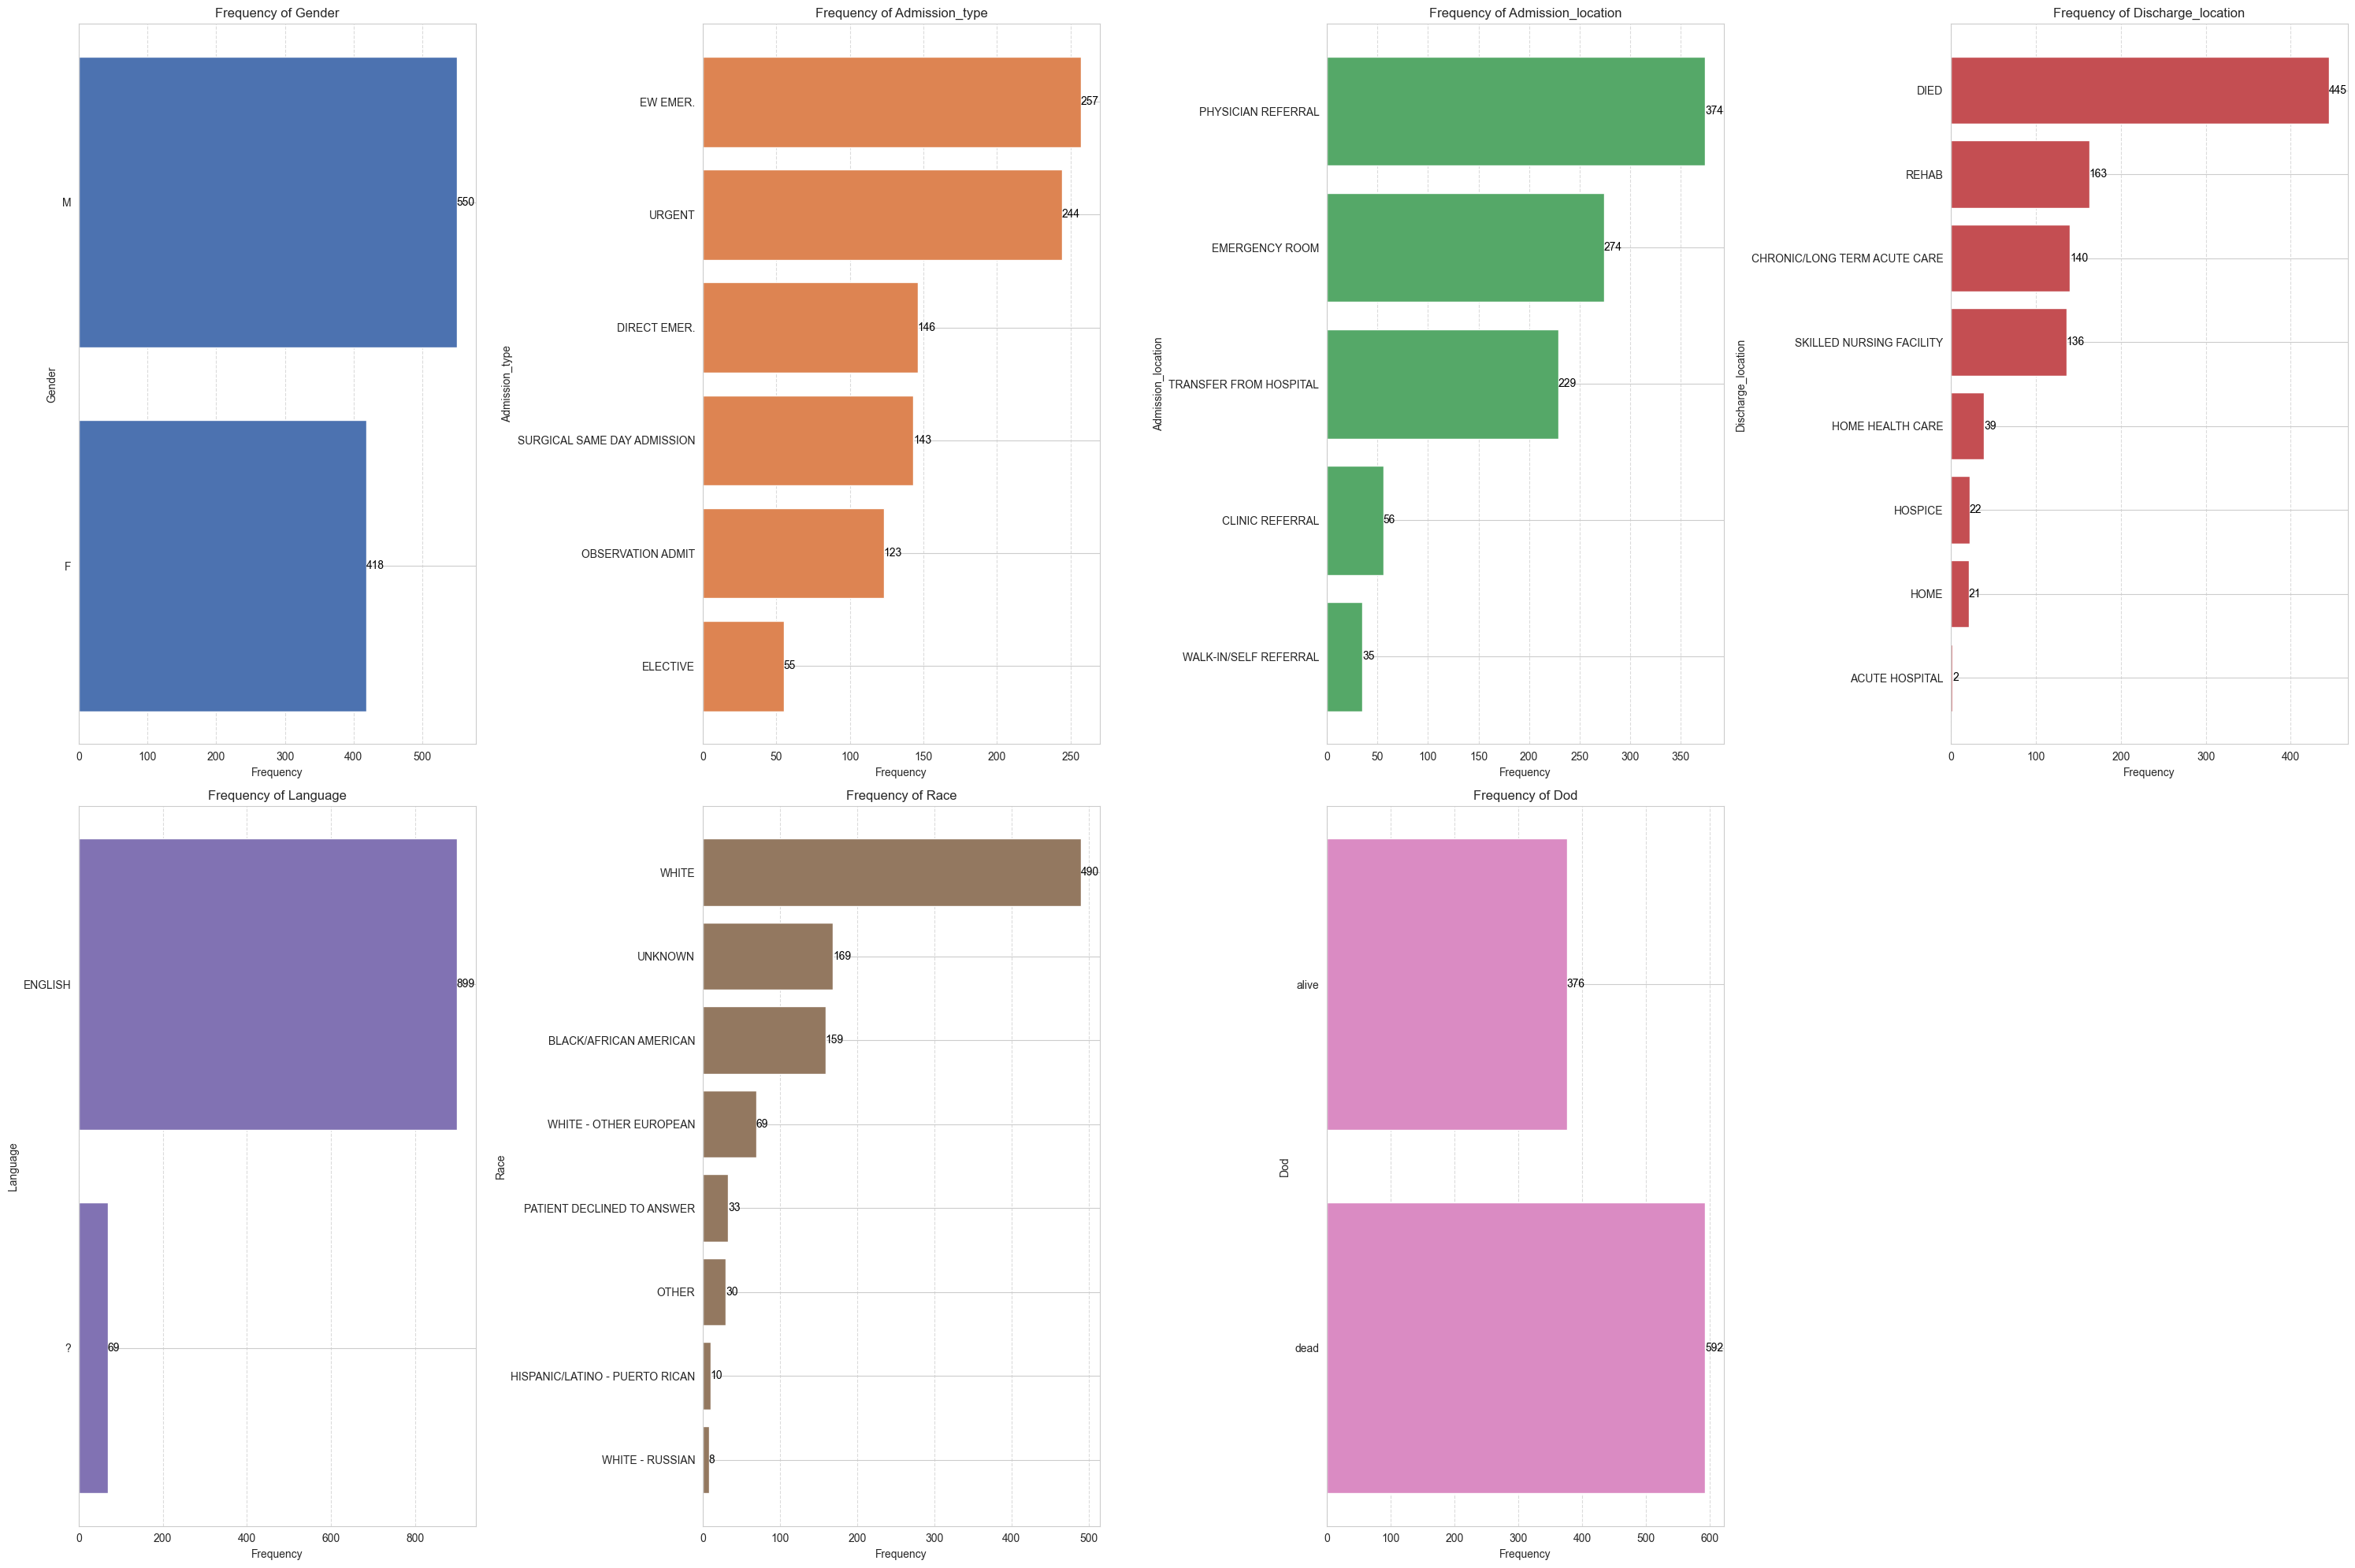

In [23]:
# Lets create a list with the categorical variables
final_table['dod'] = final_table['dod'].apply(lambda x: 'dead' if x == True else 'alive')

categorical_vars = ['gender', 'admission_type', 'admission_location', 'discharge_location', 'language', 'race', 'dod']

# Set up the plot grid
plt.figure(figsize=(30, 20))

# Define colors for the gradient
colors = sns.color_palette('deep', n_colors=len(categorical_vars))

for i, var in enumerate(categorical_vars, 1):
    # Calculate frequencies of each category
    if var == 'dod':
        category_counts = final_table[var].value_counts().sort_index()
    else:
        category_counts = final_table[var].value_counts()
        
    categories = category_counts.index
    counts = category_counts.values
    
    # Create and print a dataframe with the frequencies
    category = pd.DataFrame({var: categories, 'Frequency': counts})
    print(f'Frequency of {var.capitalize()}:\n{category}\n')
    
    # Create a horizontal bar plot with gradient colors
    plt.subplot(2, 4, i) 
    bars = plt.barh(categories, counts, color=colors[i-1])
    
    # Add data labels
    for bar, count in zip(bars, counts):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', 
                 va='center', ha='left', fontsize=10, color='black')
    
    plt.title(f'Frequency of {var.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel(var.capitalize())
    plt.gca().invert_yaxis()  # Invert y-axis to display categories from top to bottom
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability

plt.tight_layout()
plt.show()

Even with the small dataset, the gender distribution was very balanced. Most admissions were emergency cases, with the majority of patients being admitted through the emergency room. Unfortunately, many patients were discharged as "dead," indicating they passed away during hospitalization. The predominant language was English, and the majority of patients were white. However, it's important to note that the indexing for language and race data was inconsistent, making these categories less reliable. Additionally, there were more patients with a recorded date of death than those without one. (This is probably due to the repeated patients that might be skewing the data)

Frequency of Label:
                        label  Frequency
0                          pH        274
1                Free Calcium        152
2                         pO2        149
3        Calculated Total CO2        111
4  Lactate Dehydrogenase (LD)         49
5                   Uric Acid         46
6   Absolute Eosinophil Count         33
7        Creatine Kinase (CK)         30
8                 Vitamin B12         25
9     Absolute Basophil Count         22

Frequency of Fluid:
   fluid  Frequency
0  Blood        968

Frequency of Abnormal_lab:
  abnormal_lab  Frequency
0     abnormal        530
1       normal        438



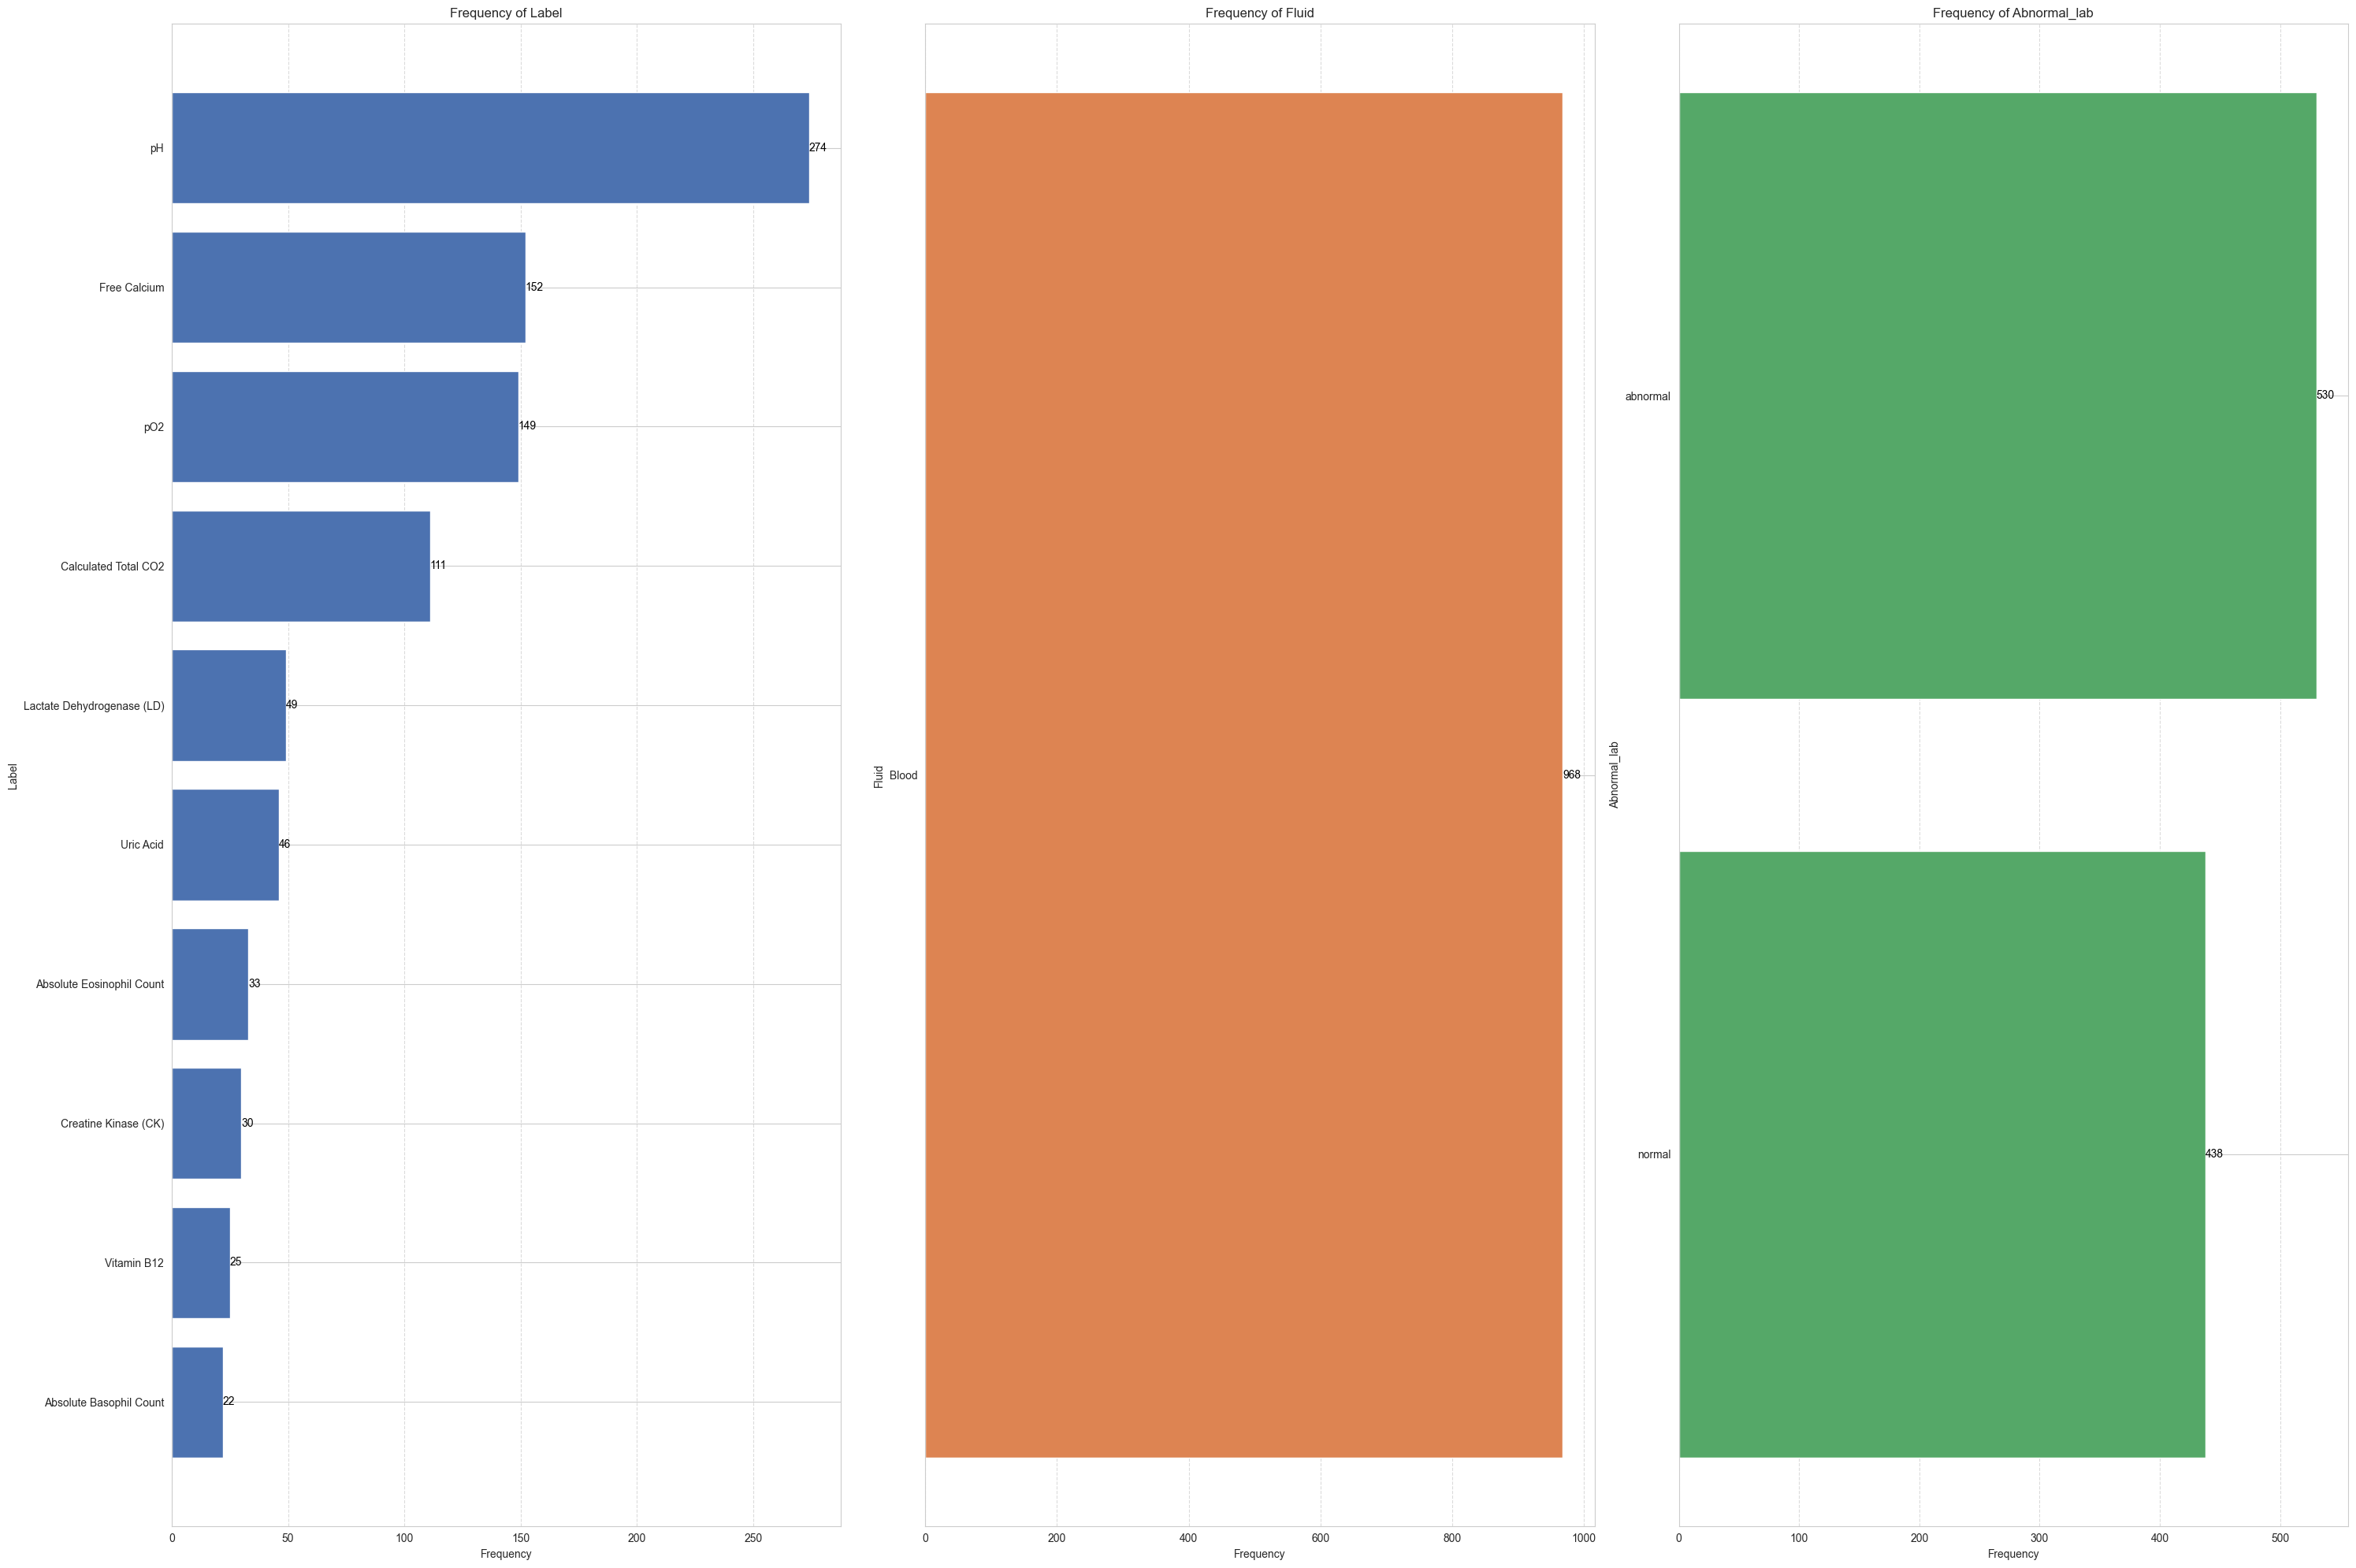

In [24]:
# Now for the labs, we have the label, fluid and abnormal_lab columns. Lets calculate the frequency and percentage of each category for these columns.

final_table['abnormal_lab'] = final_table['abnormal_lab'].apply(lambda x: 'abnormal' if x == True else 'normal')# labels for the abnormal_lab column


# Define the variables in a list
categorical_vars_lab = ['label', 'fluid', 'abnormal_lab']

# Set up the plot grid

plt.figure(figsize=(30, 20))

# Define colors for the gradient

colors = sns.color_palette('deep', n_colors=len(categorical_vars_lab))

for i, var in enumerate(categorical_vars_lab, 1):
    # Calculate frequencies of each category
    category_counts = final_table[var].value_counts().head(10)
    categories = category_counts.index
    counts = category_counts.values
    
    # Create and print a dataframe with the frequencies
    category = pd.DataFrame({var: categories, 'Frequency': counts})
    print(f'Frequency of {var.capitalize()}:\n{category}\n')
    
    # Create a horizontal bar plot with gradient colors
    plt.subplot(1, 3, i)
    bars = plt.barh(categories, counts, color=colors[i-1])
    
    # Add data labels
    for bar, count in zip(bars, counts):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', 
                 va='center', ha='left', fontsize=10, color='black')
    
    plt.title(f'Frequency of {var.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel(var.capitalize())
    plt.gca().invert_yaxis()  # Invert y-axis to display categories from top to bottom
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
    
plt.tight_layout()
plt.show()



The most frequently measured labs were pH and free calcium, with blood being the most common fluid type. Additionally, there were more abnormal lab results than normal ones.

The main lab tests that are relevant for stroke patients are the ones that measure the levels of glucose, and cholesterol, as Diabetes mellitus and cardiovascular disease are important risk factors for stroke. Lets filter the final table dataframe to only include these tests. [4]


In [32]:
# Define the relevant lab tests

# i will create a dictionary with the relevant lab tests and their corresponding itemids

CVRF_dict = { "Glucose": 50809, "Cholesterol": 50905, "A1C%": 50852}

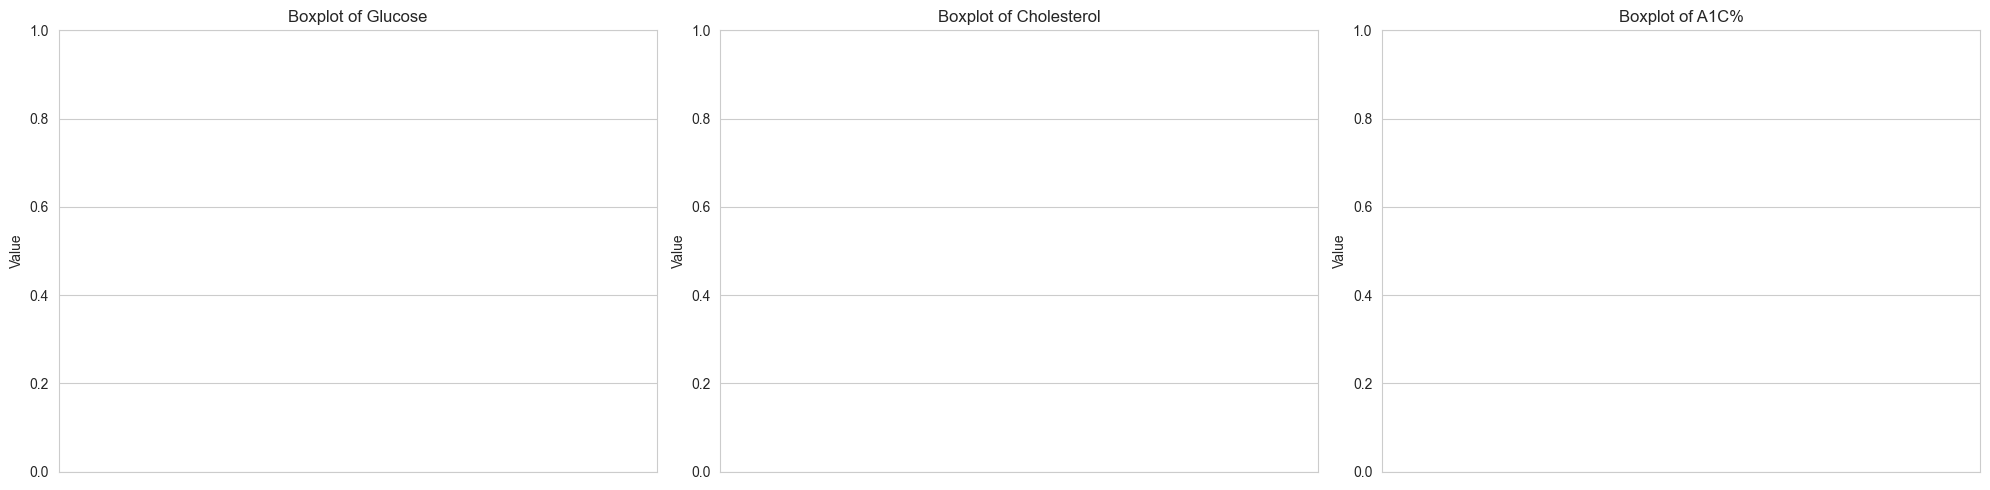

In [33]:
#lets filter the final table to only include the relevant lab tests and plot the distribution of the values.

# Filter the final table 
filtered_final_table = final_table[final_table['itemid'].isin(list(CVRF_dict.values()))]

# Determine the number of rows needed for the subplot grid
num_tests = len(CVRF_dict)
num_rows = math.ceil(num_tests / 3)

# Set up the plot grid
plt.figure(figsize=(20, 5 * num_rows))

# Define colors for the gradient
colors = sns.color_palette('deep', n_colors=num_tests)

for i, (test, itemid) in enumerate(CVRF_dict.items()):
    # Filter the data for the specific lab test
    test_data = filtered_final_table[filtered_final_table['itemid'] == itemid]
    
    # Create a boxplot for the lab test values
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(y=test_data['valuenum'], color=colors[i])
    plt.title(f'Boxplot of {test}')
    plt.ylabel('Value')
    
plt.tight_layout()
plt.show()

In the small sample of this population, no tests relevant to cardiovascular disease or diabetes were conducted. Perhaps in the expanded sample, such testing will be included.

long_title
Hyperkalemia                                                                                                                                                         33
Patient room in hospital as the place of occurrence of the external cause                                                                                            28
Physical restraint status                                                                                                                                            22
Other medical procedures as the cause of abnormal reaction of the patient, or of later complication, without mention of misadventure at the time of the procedure    21
Operating room of hospital as the place of occurrence of the external cause                                                                                          20
                                                                                                                                                     

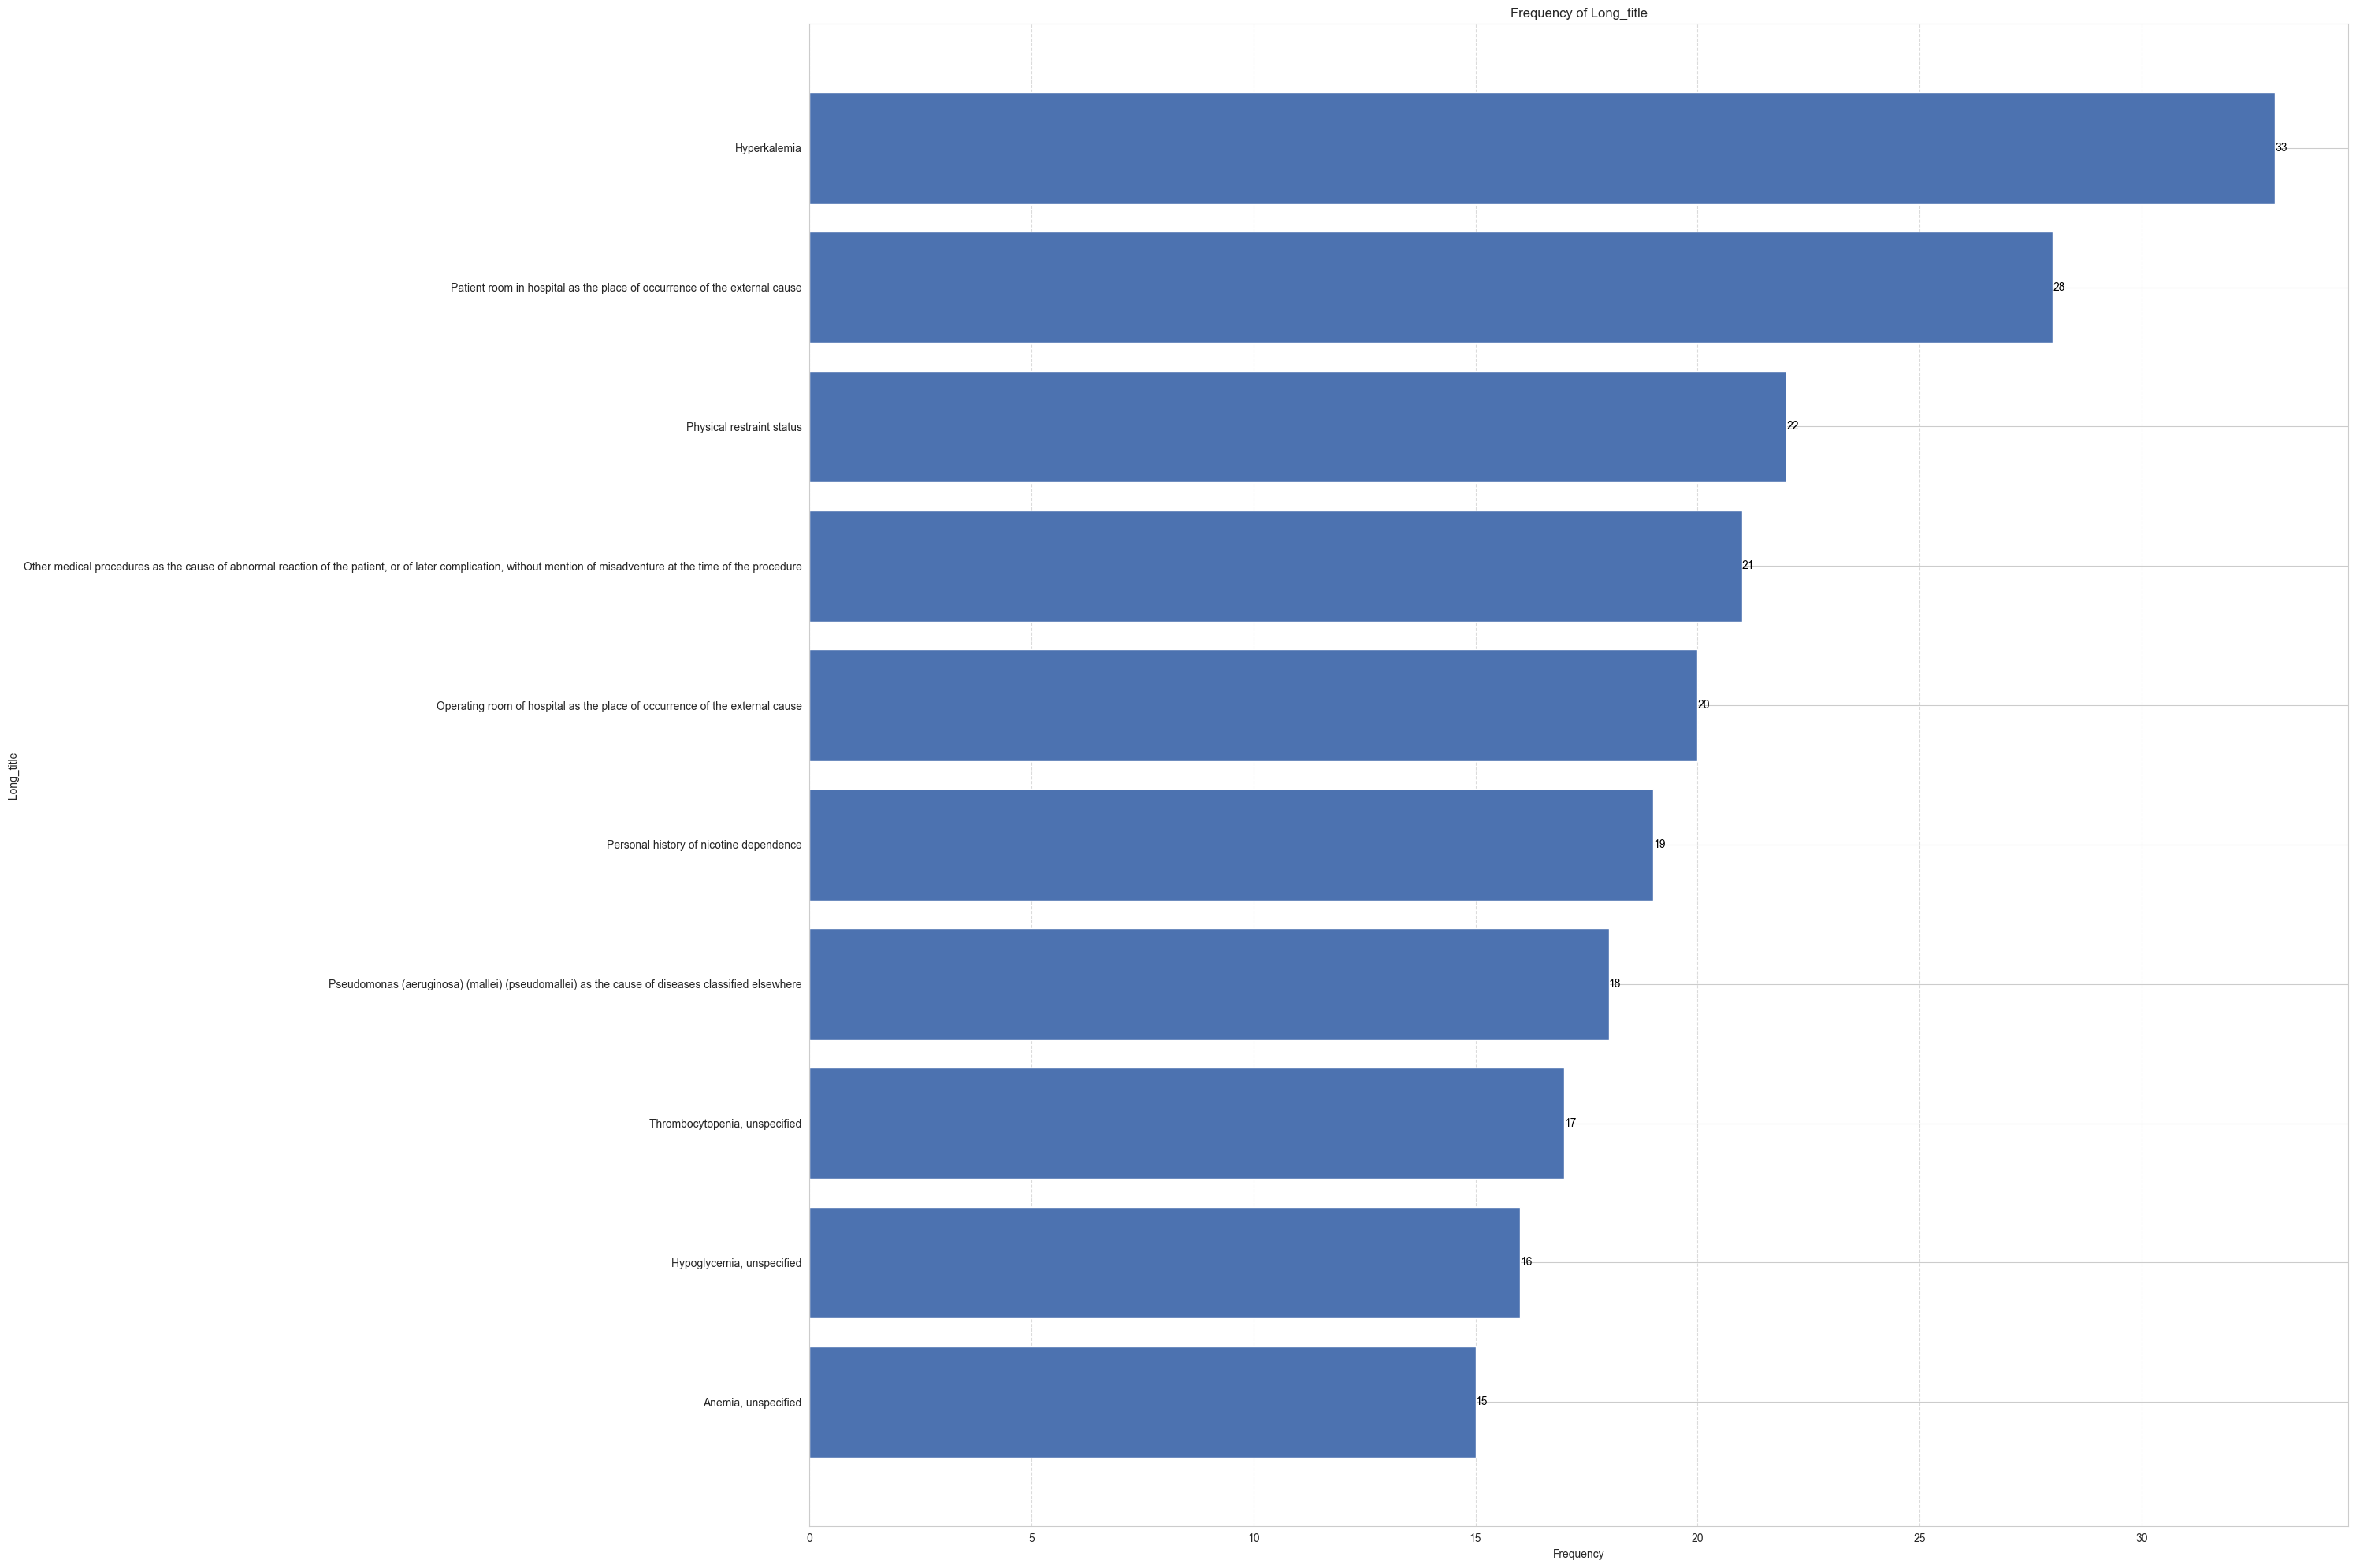

In [27]:
# Now for the diagnoses, we have the long_title column. Lets calculate the frequency and percentage of each category for this column.

# Define categorical variables

categorical_vars_icd = ['long_title']

#there are many categories with just one registry, so we will only display the categories with more than 100 registries.

print(final_table['long_title'].value_counts())

# Set up the plot grid

plt.figure(figsize=(30, 20))

# Define colors for the gradient

colors = sns.color_palette('deep', n_colors=len(categorical_vars_icd))
for i, var in enumerate(categorical_vars_icd, 1):
    # Calculate frequencies of each category
    category_counts = final_table[var].value_counts()
    categories = category_counts.index[:10]  # Select only the top 10 categories by frequency
    counts = category_counts[:10].values     # Corresponding counts for the top 10 categories
    
    # Create and print a dataframe with the frequencies
    category = pd.DataFrame({var: categories, 'Frequency': counts})
    print(f'Frequency of {var.capitalize()}:\n{category}\n')
    
    # Create a horizontal bar plot with gradient colors
    plt.subplot(1, 1, i)
    bars = plt.barh(categories, counts, color=colors[i-1])
    
    # Add data labels
    for bar, count in zip(bars, counts):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', 
                 va='center', ha='left', fontsize=10, color='black')
    
    plt.title(f'Frequency of {var.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel(var.capitalize())
    plt.gca().invert_yaxis()  # Invert y-axis to display categories from top to bottom
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
    
plt.tight_layout()
plt.show()



In this sample, the most common diagnosed condition was hyperkalemia, followed by non-specific conditions like "patient room in hospital as the place of occurrence of the external cause." While the latter is primarily used for billing purposes, it should be excluded from clinical analysis as it lacks relevance to medical applications.

# Multivariate analysis
Lets plot the bivariate distribution of multiple features! Starting with age, gender and race 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6272\3487753142.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['truncated_long_title'] = filtered_data['long_title'].apply(lambda x: ' '.join(x.split()[:5]))


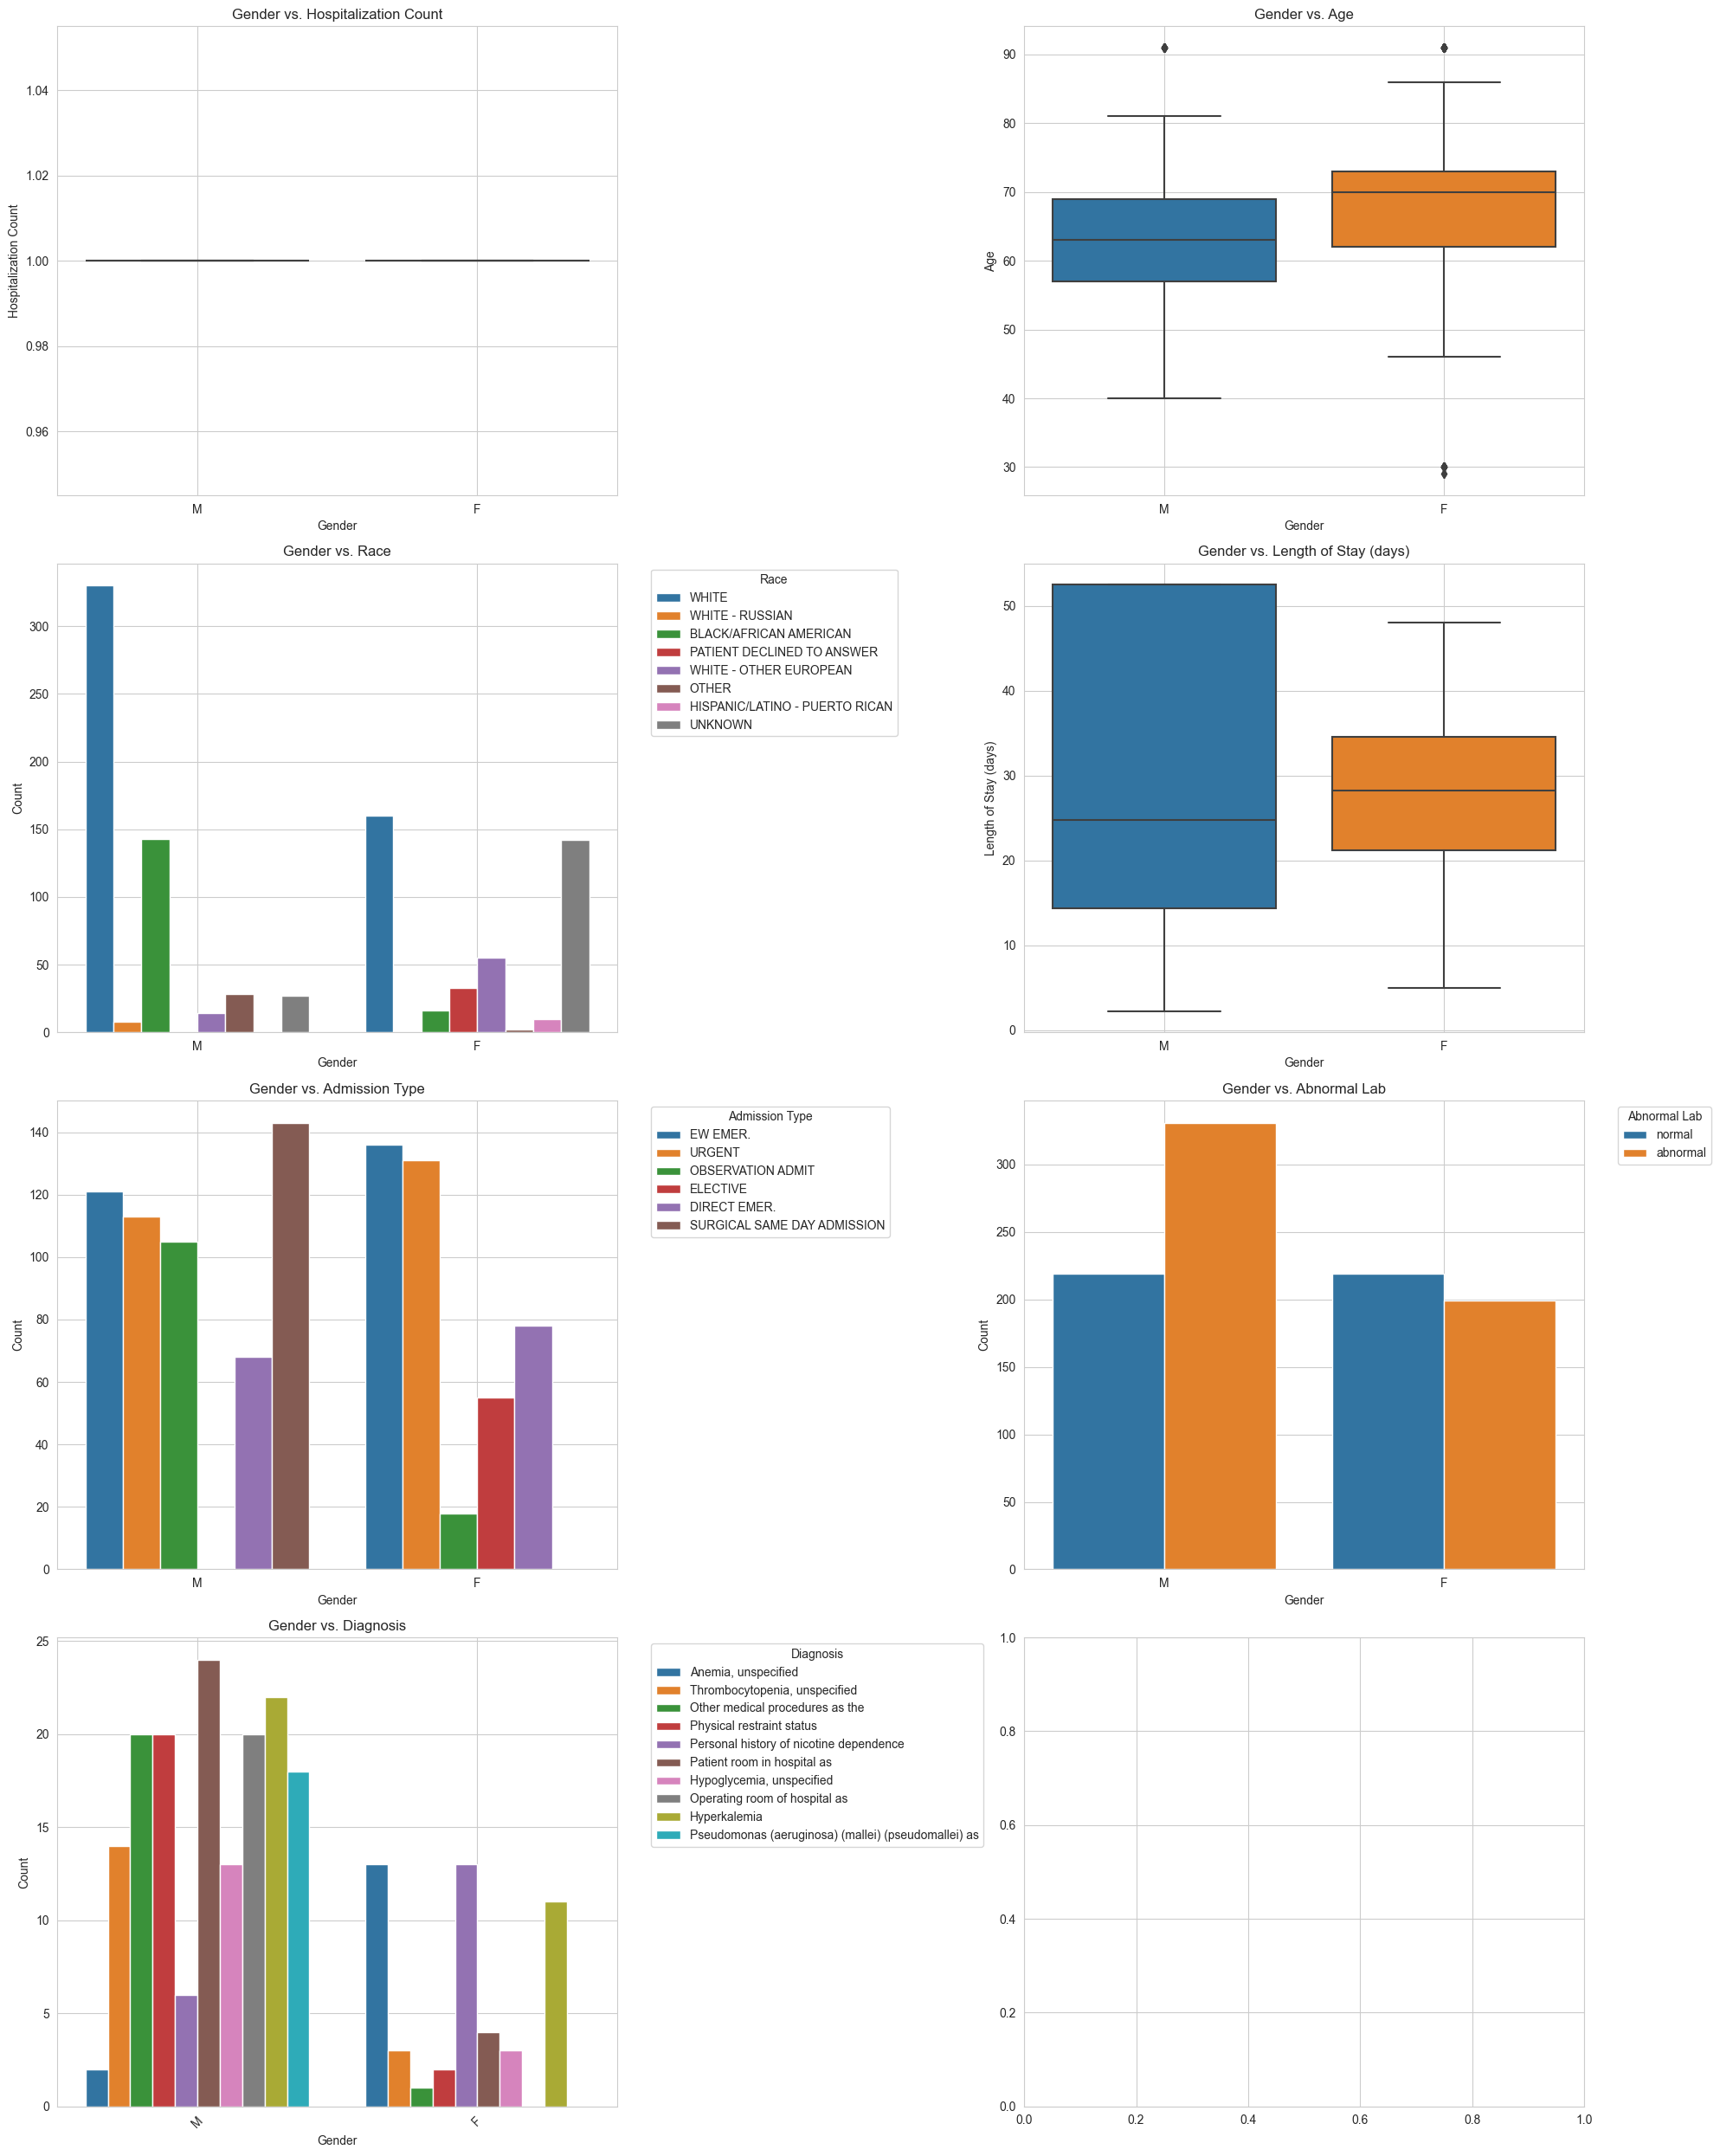

In [59]:
# For gender:

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the variables to plot
variables_to_plot = [
    ('num_hospitalizations', 'Hospitalization Count', 'box'),
    ('anchor_age', 'Age', 'box'),
    ('race', 'Race', 'count'),
    ('length_of_stay', 'Length of Stay (days)', 'box'),
    ('admission_type', 'Admission Type', 'count'),
    ('abnormal_lab', 'Abnormal Lab', 'count'),
    ('long_title', 'Diagnosis', 'count')
]

# Create a 4x2 grid for subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 25))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each variable against gender
for i, (var, title, plot_type) in enumerate(variables_to_plot):
    if plot_type == 'box':
        # Boxplot for numeric variables
        sns.boxplot(x='gender', y=var, data=final_table, ax=axes[i])
        axes[i].set_ylabel(title)
    elif plot_type == 'count':
        if var == 'long_title':
            # Filter data for the first 10 long titles
            first_10_long_titles = final_table[var].value_counts().index[:10]
            filtered_data = final_table[final_table[var].isin(first_10_long_titles)]
            
            # Truncate long titles to maximum 5 words
            filtered_data['truncated_long_title'] = filtered_data['long_title'].apply(lambda x: ' '.join(x.split()[:5]))
            
            sns.countplot(x='gender', hue='truncated_long_title', data=filtered_data, ax=axes[i])
            axes[i].legend(title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[i].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability
        else:
            # Countplot with hue for categorical variables
            sns.countplot(x='gender', hue=var, data=final_table, ax=axes[i])
            axes[i].legend(title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        axes[i].set_ylabel('Count')
    
    axes[i].set_title(f'Gender vs. {title}')
    axes[i].set_xlabel('Gender')
    axes[i].grid(True)


# Adjust layout and display
plt.tight_layout()
plt.show()


Males, on average, had a longer length of stay compared to females. Although females were older, they were more likely than males to have normal lab results. Both genders predominantly belonged to the white population, but the proportion of unknown races was higher among females. Males were more frequently admitted for surgical procedures, whereas females were predominantly admitted in emergency or urgent situations. The top clinical diagnosis for females was anemia, while for males it was hyperkalemia.

*This might change with an increased sample

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6272\3613146476.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = df.groupby([group_col, count_col]).size().unstack(fill_value=0)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6272\3613146476.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

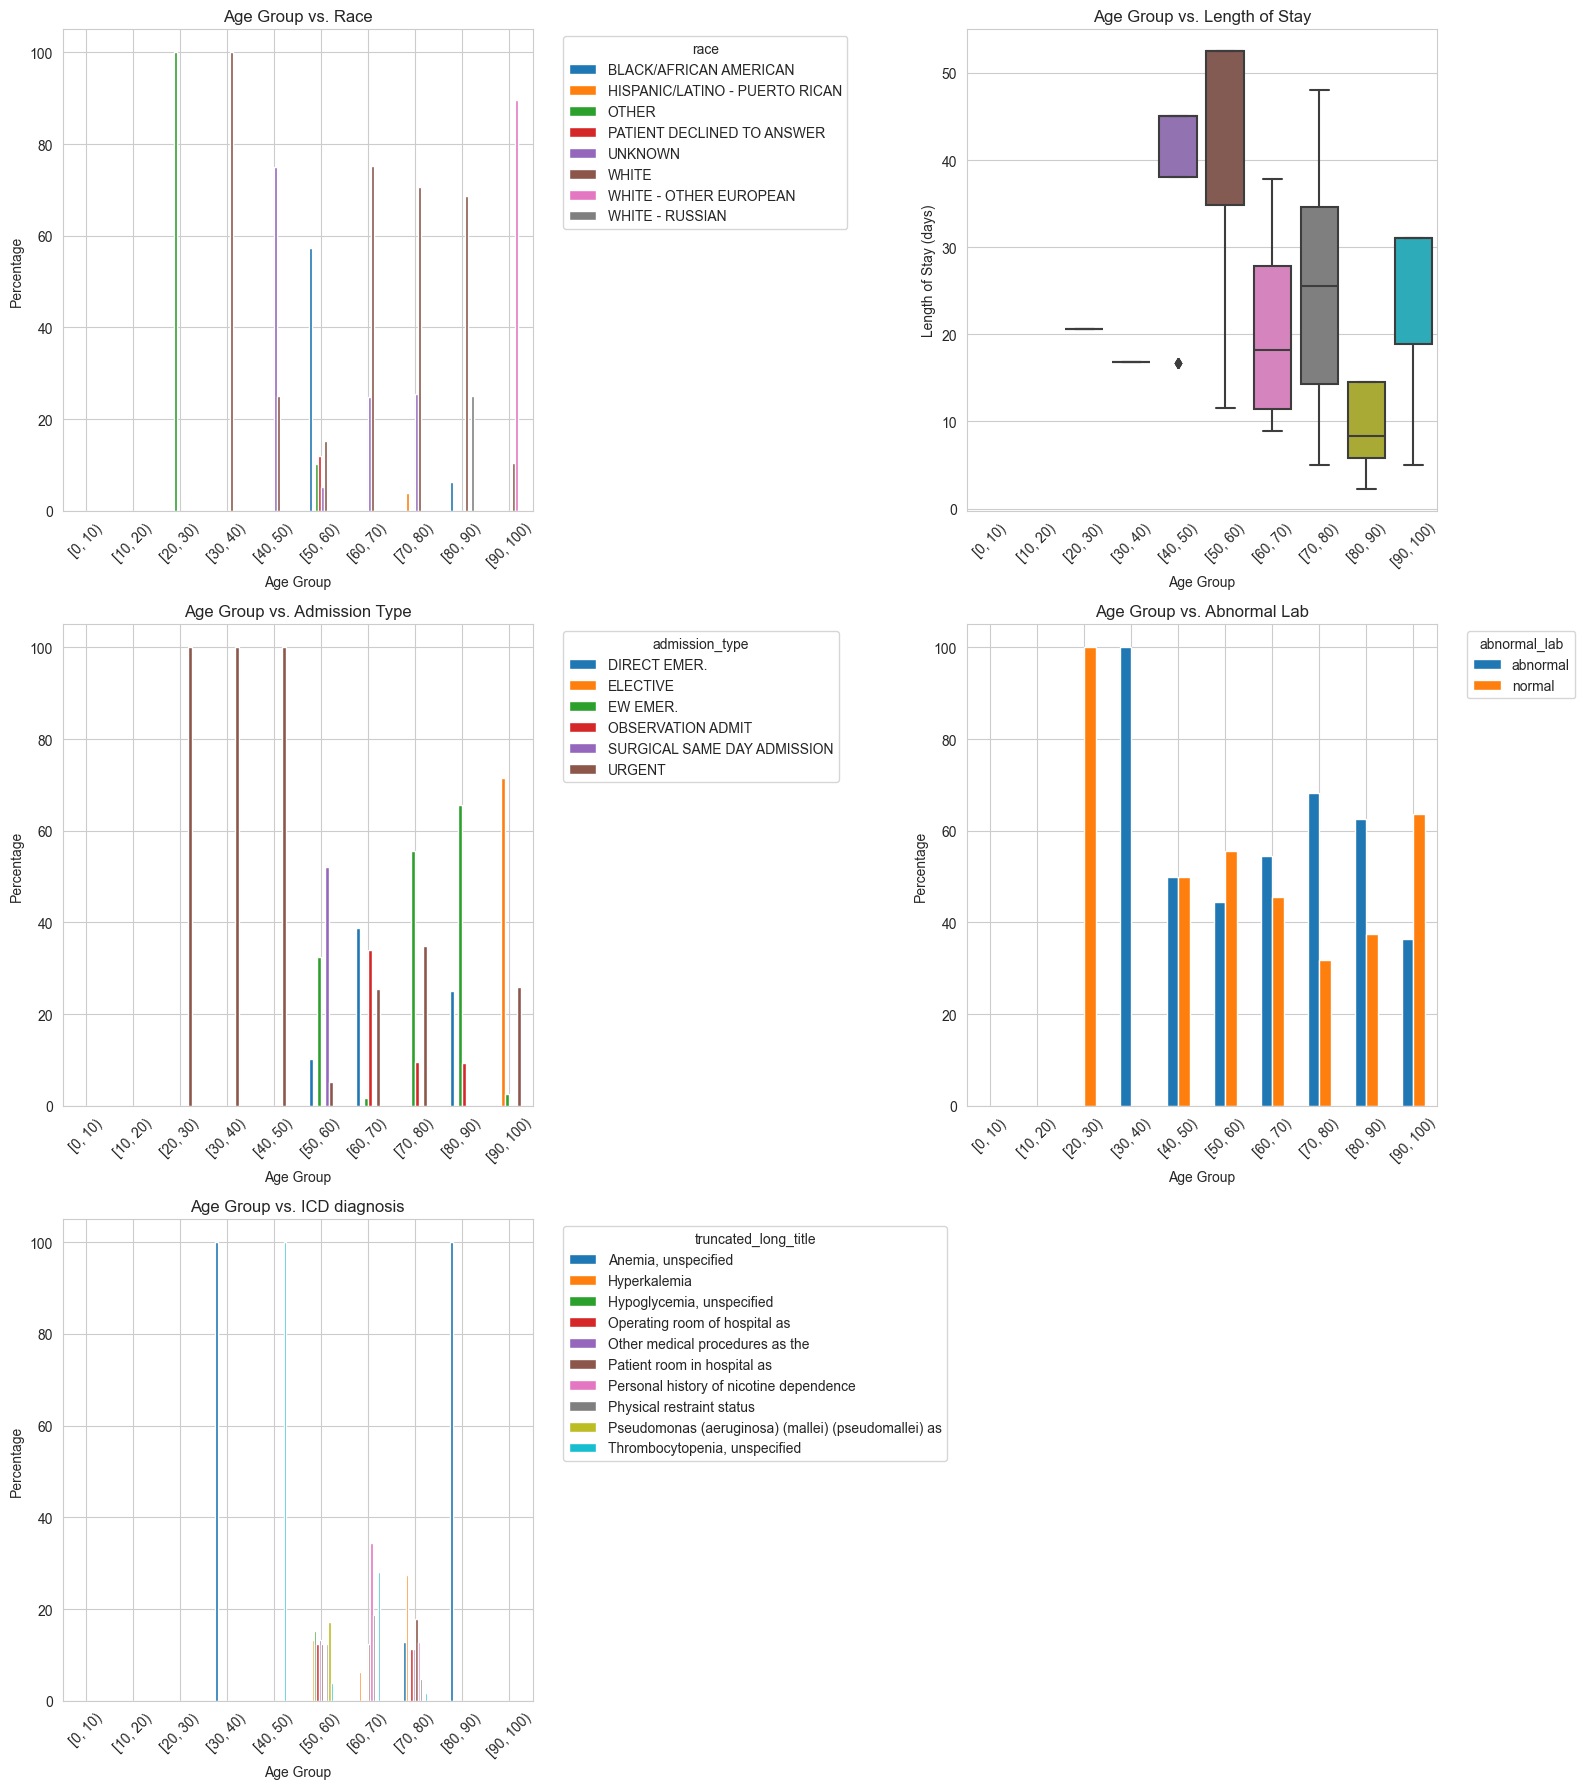

In [58]:
#Age: 

# Create 10-year age groups
final_table['age_group'] = pd.cut(final_table['anchor_age'], bins=range(0, 110, 10), right=False)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Function to calculate percentages
def calculate_percentages(df, group_col, count_col):
    group_counts = df.groupby([group_col, count_col]).size().unstack(fill_value=0)
    group_percentages = group_counts.div(group_counts.sum(axis=1), axis=0) * 100
    return group_percentages

# Function to create percentage plots with truncated labels
def create_percentage_plot(ax, data, group_col, count_col, title, xlabel, ylabel, rotation=0):
    percentages = calculate_percentages(data, group_col, count_col)
    percentages.plot(kind='bar', stacked=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=count_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)

# Function to create box plots
def create_box_plot(ax, x, y, data, title, xlabel, ylabel, rotation=0):
    sns.boxplot(x=x, y=y, data=data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)

# Function to truncate long titles
def truncate_long_title(title, max_words=5):
    return ' '.join(title.split()[:max_words])

# Create the figure and axes
fig, axs = plt.subplots(3, 2, figsize=(16, 18))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Create the plots
create_percentage_plot(axs[0], final_table, 'age_group', 'race', 'Age Group vs. Race', 'Age Group', 'Percentage', rotation=45)
create_box_plot(axs[1], 'age_group', 'length_of_stay', final_table, 'Age Group vs. Length of Stay', 'Age Group', 'Length of Stay (days)', rotation=45)
create_percentage_plot(axs[2], final_table, 'age_group', 'admission_type', 'Age Group vs. Admission Type', 'Age Group', 'Percentage', rotation=45)
create_percentage_plot(axs[3], final_table, 'age_group', 'abnormal_lab', 'Age Group vs. Abnormal Lab', 'Age Group', 'Percentage', rotation=45)

# Plot Age Group vs. First 10 Long Titles with truncated labels
first_10_long_titles = final_table['long_title'].value_counts().index[:10]
filtered_data = final_table[final_table['long_title'].isin(first_10_long_titles)]
filtered_data['truncated_long_title'] = filtered_data['long_title'].apply(lambda x: truncate_long_title(x, max_words=5))
create_percentage_plot(axs[4], filtered_data, 'age_group', 'truncated_long_title', 'Age Group vs. ICD diagnosis', 'Age Group', 'Percentage', rotation=45)

# Hide extra subplots that are not used
for ax in axs[5:]:
    ax.set_visible(False)
    
# Adjust layout
plt.tight_layout()
plt.show()


The peak length of stay was observed in the 50-60 age group, which was predominantly composed of African Americans. Apart from the 90-100 age group, older age groups generally had a higher proportion of abnormal lab results

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6272\3432304684.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['truncated_long_title'] = filtered_data['long_title'].apply(lambda x: ' '.join(x.split()[:5]))


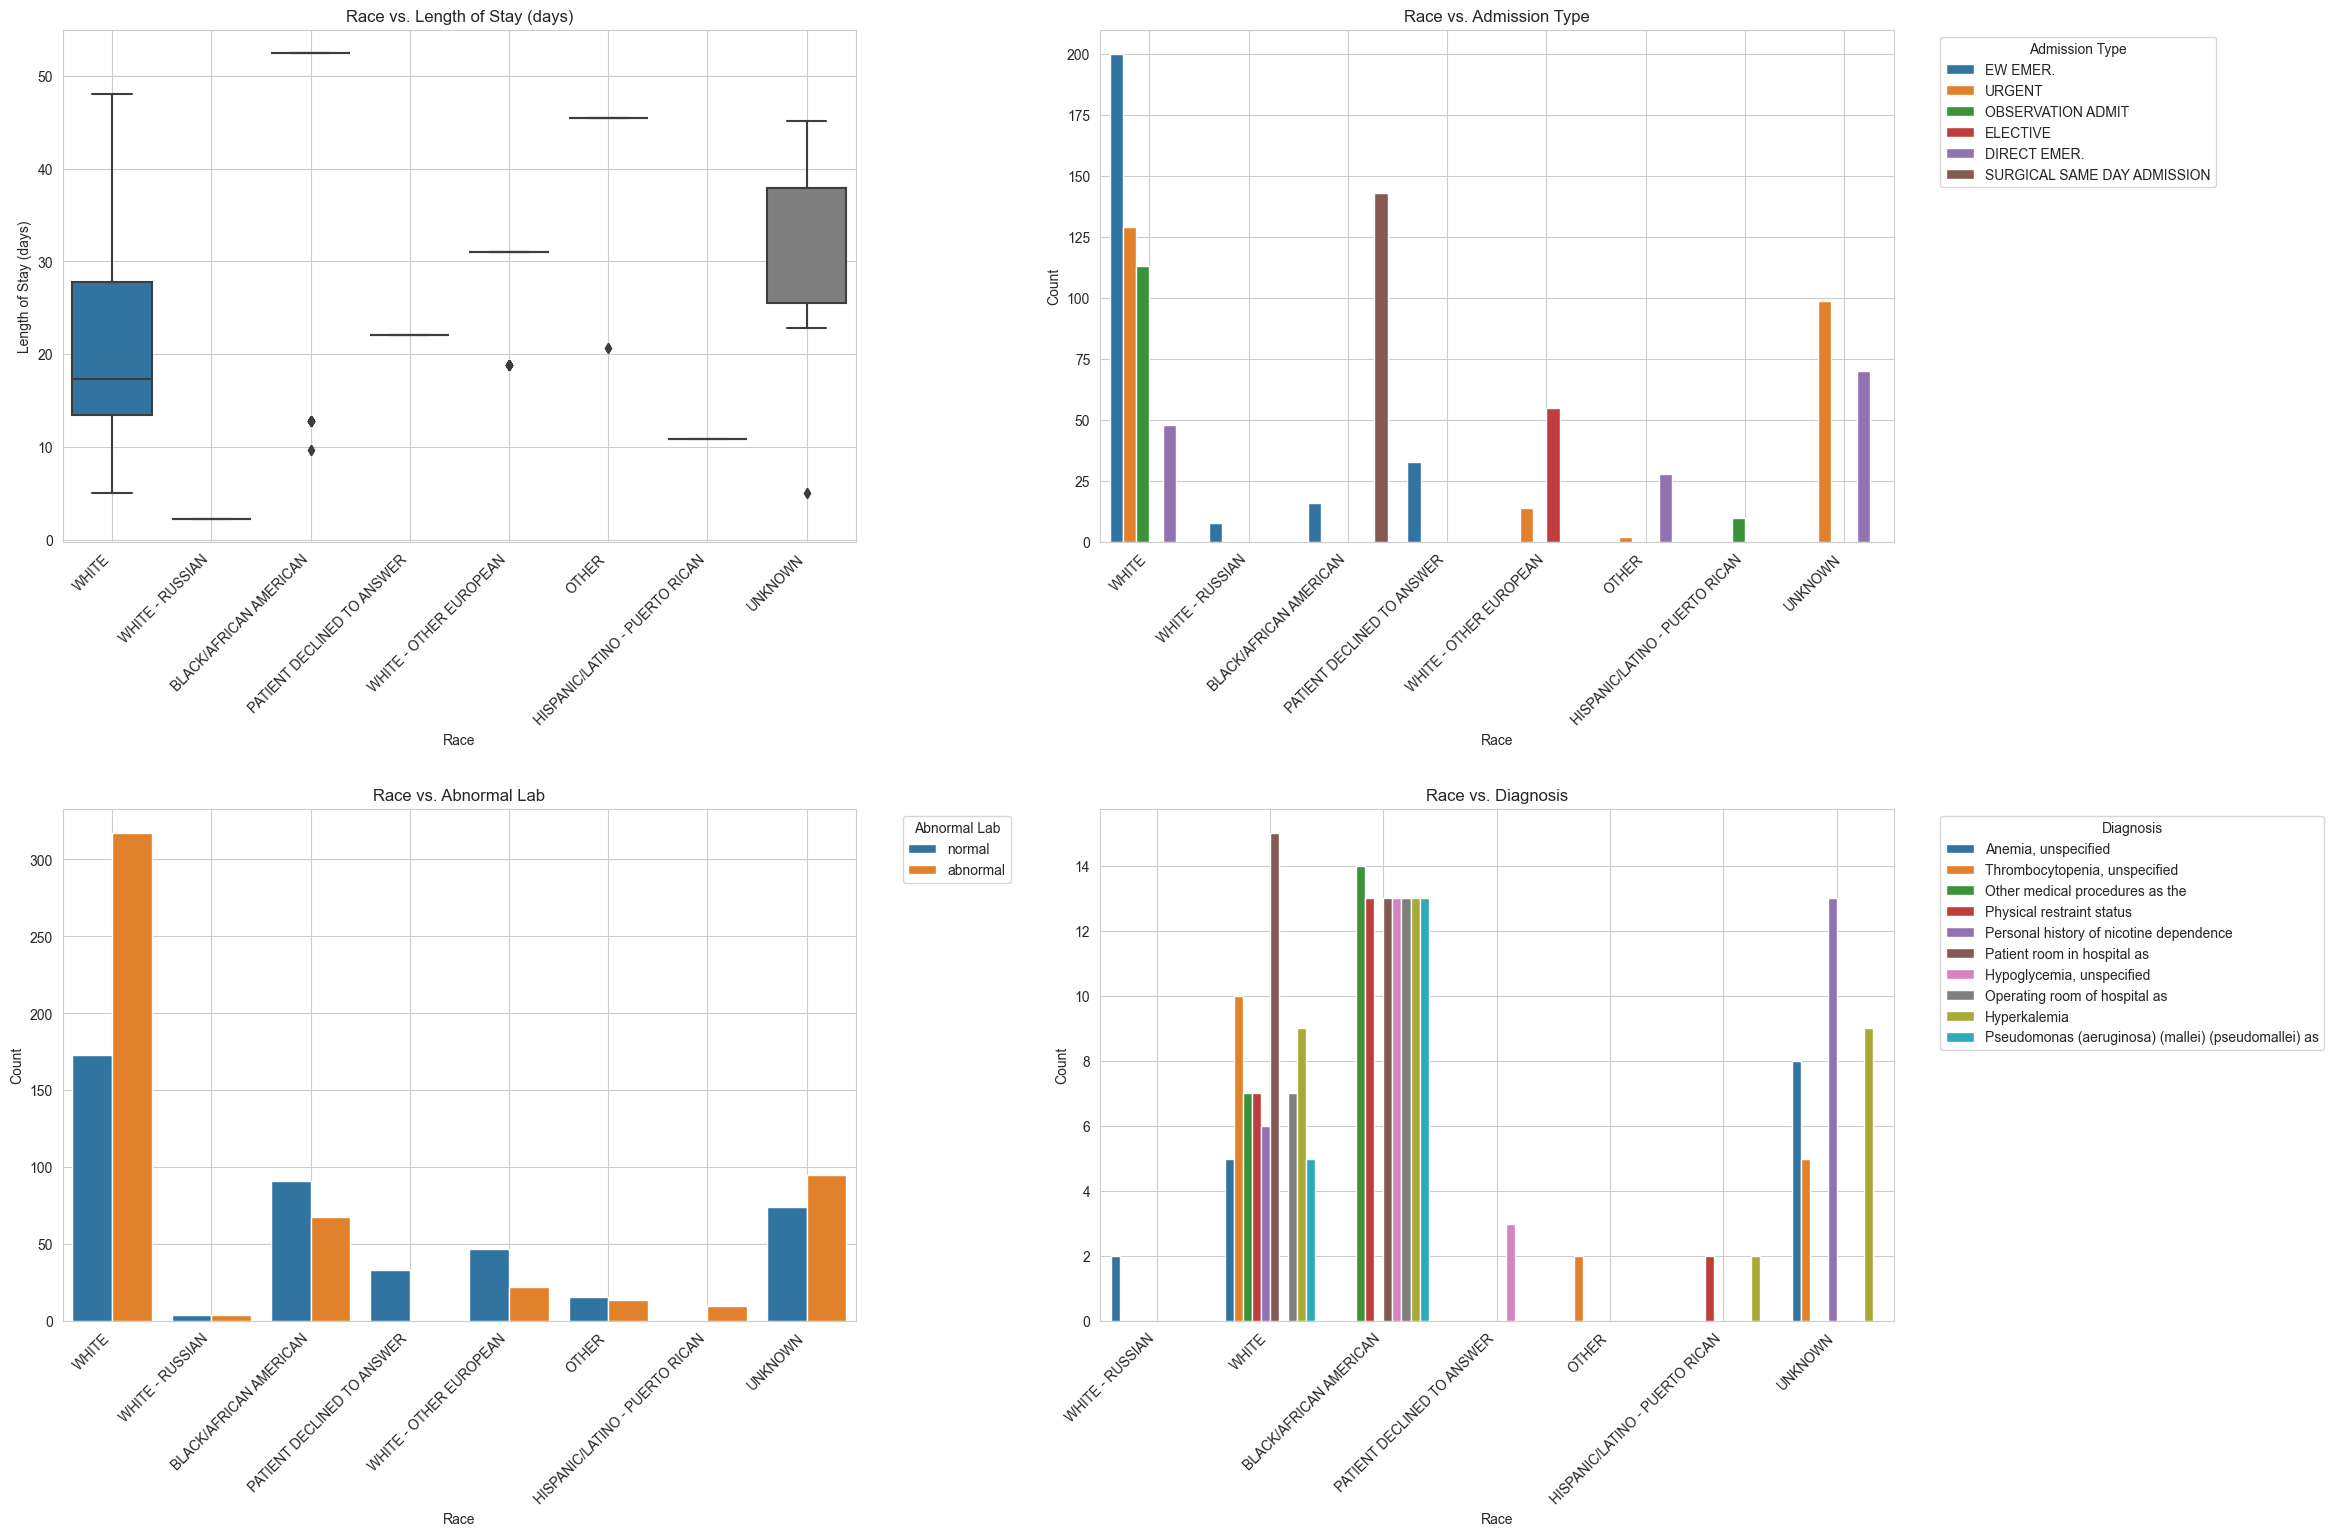

In [75]:
#Race:

# Lets set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the variables to plot
variables_to_plot = [
    ('length_of_stay', 'Length of Stay (days)', 'box'),
    ('admission_type', 'Admission Type', 'count'),
    ('abnormal_lab', 'Abnormal Lab', 'count'),
    ('long_title', 'Diagnosis', 'count')
]

# Create a 2x2 grid for subplots with wider figure size
fig, axes = plt.subplots(2, 2, figsize=(24, 16))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each variable against race
for i, (var, title, plot_type) in enumerate(variables_to_plot):
    if plot_type == 'box':
        # Boxplot for numeric variables
        sns.boxplot(x='race', y=var, data=final_table, ax=axes[i])
        axes[i].set_ylabel(title)
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right') 
    elif plot_type == 'count':
        if var == 'long_title':
            # Filter data for the first 10 long titles
            first_10_long_titles = final_table[var].value_counts().index[:10]
            filtered_data = final_table[final_table[var].isin(first_10_long_titles)]
            
            # Truncate long titles to maximum 5 words
            filtered_data['truncated_long_title'] = filtered_data['long_title'].apply(lambda x: ' '.join(x.split()[:5]))
            
            sns.countplot(x='race', hue='truncated_long_title', data=filtered_data, ax=axes[i])
            axes[i].legend(title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')  # Rotate and adjust alignment of x-axis labels
        else:
            # Countplot
            sns.countplot(x='race', hue=var, data=final_table, ax=axes[i])
            axes[i].legend(title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right') 
        
        axes[i].set_ylabel('Count')
    
    axes[i].set_title(f'Race vs. {title}')
    axes[i].set_xlabel('Race')
    axes[i].grid(True)

# Adjust spacing between subplots
plt.tight_layout(pad=3.0)

# Hide extra subplots that are not used
for j in range(len(variables_to_plot), len(axes)):
    axes[j].set_visible(False)

# Display the plot
plt.show()


For future instances of the MIMIC database, merging the categories "unknown" and "patient declined to answer" would eliminate redundancy, as they do not provide additional information.

On average, White patients had a shorter length of stay compared to other races, despite having the highest number of urgent admissions. In contrast, African American patients exhibited more normal laboratory values than abnormal ones.

The primary diagnoses across all races were administrative and non-clinical, primarily used for billing purposes.

 # Deep Learning model creation! <a name='raw'></a>

Lets start with the model creation! First, lets select the features we are going to work with and create a df with the outcome (stroke vs non stroke). 
- I will import the raw waveforms using the wfdb library.
- I will create an additional column that will create the binary classifier that will be the outcome (stroke vs no stroke)

The following cell was my attempt to work with the ECG database as a zipped file, aimed at overcoming the computational limitations I currently face. This approach will be revised once I set up the virtual machine.

In [80]:
'''
from zipfile import ZipFile

zip_file = ZipFile(r'C:\Users\LENOVO\Desktop\codigos\Python\MIMICS_AN\mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}


# Path to the ECG data files
path1 = r"C:/Users/LENOVO/Desktop/codigos/Python/MIMICS_AN/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0.zip"

def wavelengths(df, path1):
    data = []
    with zipfile.ZipFile(path1, 'r') as z:
        for file_name in df['path']:
            hea_path = file_name + ".hea"
            dat_path = file_name + ".dat"
            
            try:
                with z.open(hea_path) as hea_file, z.open(dat_path) as dat_file:
                    # Read the header and data files
                    header = io.BytesIO(hea_file.read())
                    dat = io.BytesIO(dat_file.read())
                    # Create a record from the header and dat files
                    record = wfdb.rdrecord(None, sampfrom=0, sampto=None, physical=False, pn_dir='local')
                    data.append(record.p_signal)
            except KeyError as e:
                print(f"Error accessing file: {e}")
    
    data = np.array(data)
    return data

# Import raw data
feature_raw = wavelengths(final_table, path1)
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 73-74: truncated \UXXXXXXXX escape (2009970854.py, line 38)

In [ ]:
# Import raw data with the wdfb library and create a new array with it 

def load_raw_data(df, sampling_rate, path):
    data = [wfdb.rdsamp(path1+f) for f in df.path]
    data = np.array([signal for signal, meta in data])
    return data

path1 = "INSERT BUCKET PATH HERE" # I will change the path depending on where its stored in the virtual machine 

# Load raw signal data

raw_waveforms = load_raw_data(final_table, path1)


Now for the feature selection and model creation, lets find the patients that were classified as having a stroke. This will be our "output".  

Number of unique patients with stroke: 0
Number of unique patients in the final table: 45
Axes(0.125,0.11;0.698618x0.77)
    subject_id gender  anchor_age  anchor_year_group   dod   hadm_id  \
29    10780878      M          75             2009.0  dead  24037790   
30    10780878      M          75             2009.0  dead  24037790   
31    10780878      M          75             2009.0  dead  24037790   
32    10780878      M          75             2009.0  dead  24037790   
33    10780878      M          75             2009.0  dead  24037790   

             admittime           dischtime admission_type admission_location  \
29 2114-11-10 16:34:00 2114-11-25 12:43:00       EW EMER.     EMERGENCY ROOM   
30 2114-11-10 16:34:00 2114-11-25 12:43:00       EW EMER.     EMERGENCY ROOM   
31 2114-11-10 16:34:00 2114-11-25 12:43:00       EW EMER.     EMERGENCY ROOM   
32 2114-11-10 16:34:00 2114-11-25 12:43:00       EW EMER.     EMERGENCY ROOM   
33 2114-11-10 16:34:00 2114-11-25 12:43:00    

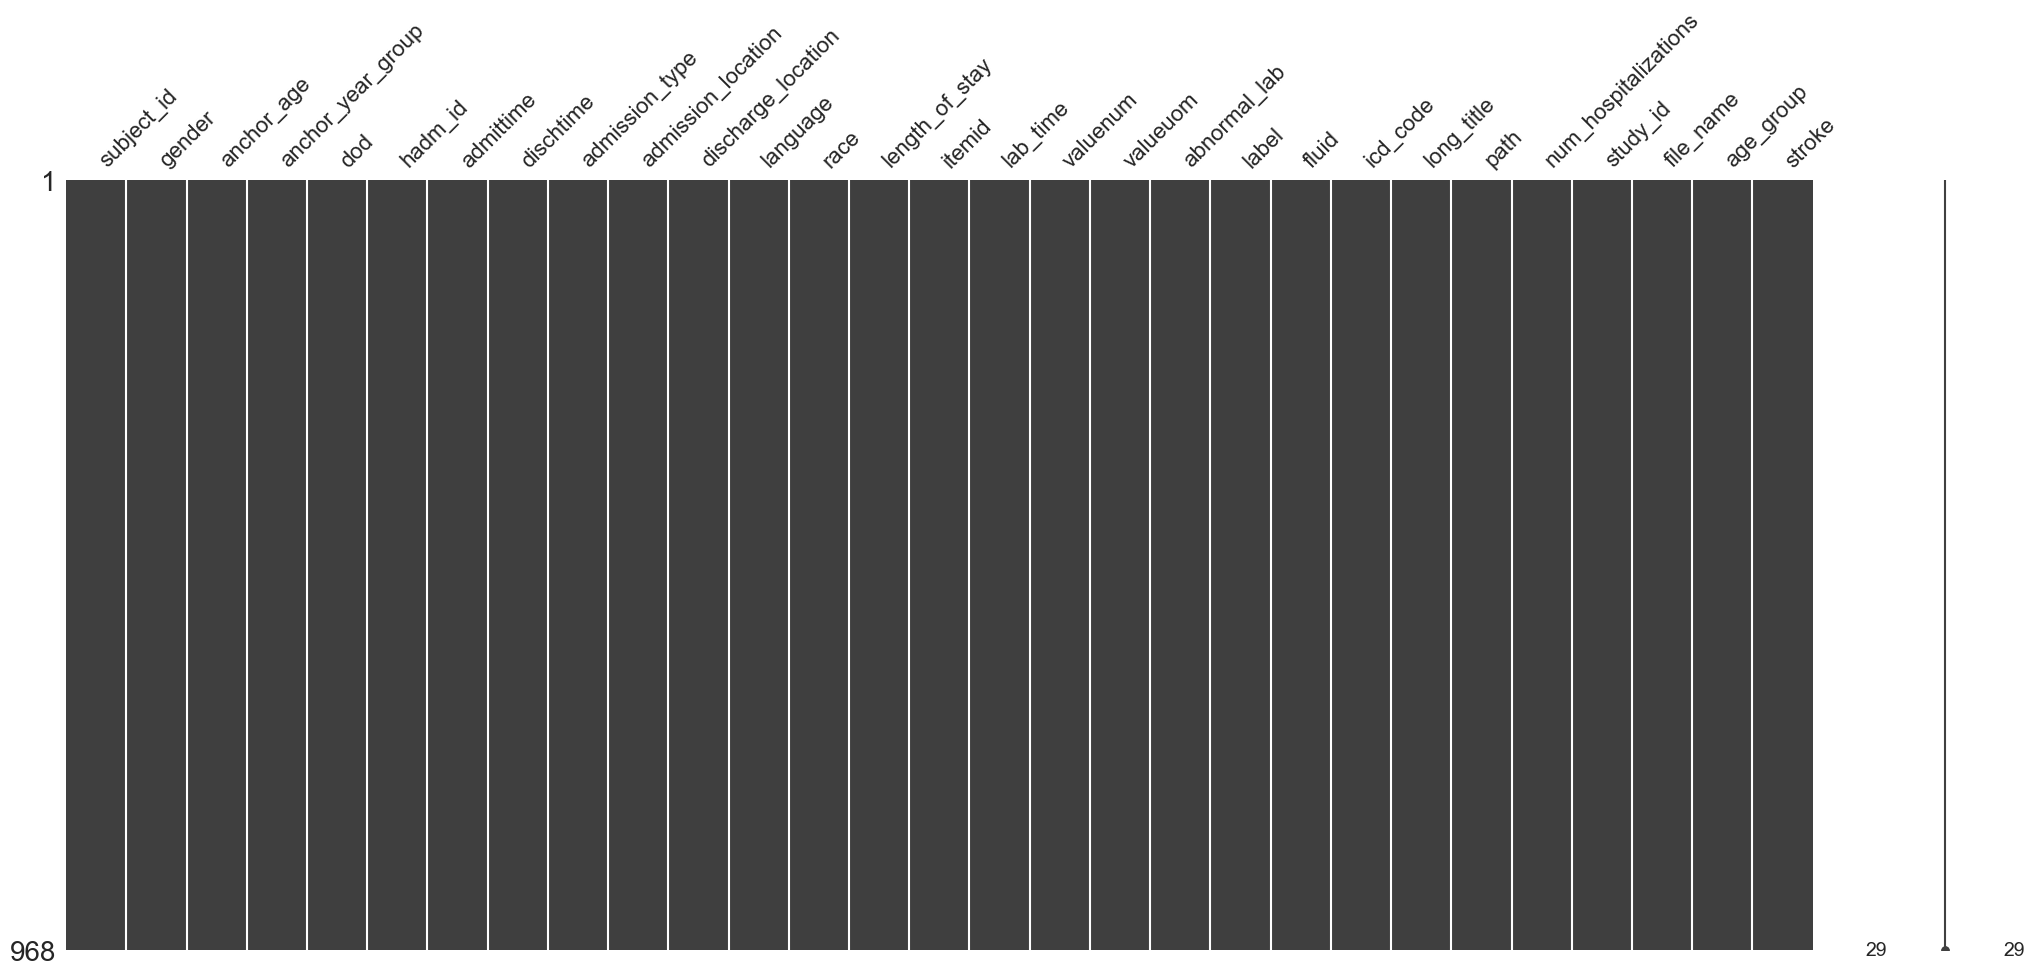

In [81]:
# Create a list of the ICD codes related to stroke
icd_codes = {
    "ischemic_with_infarction": {
        "ICD-9": [
            "433x0", "43400", "43410", "43490", "43411", "43491", "436"
        ],
        "ICD-10": [
            "I630", "I631", "I632", "I633", "I634", "I635", "I636", "I638", "I639"
        ]
    },
    "hemorrhagic": {
        "ICD-9": [
            "430", "431", "432x"
        ],
        "ICD-10": [
            "I600", "I601", "I602", "I603", "I604", "I609", 
            "I610", "I611", "I612", "I619"
        ]
    },
    "transient_ischemic_attack": {
        "ICD-9": [
            "435", "4350"
        ],
        "ICD-10": [
            "G459"
        ]
    }
}

# Define the ICD-9 and 10 codes for stroke 

stroke_icd9_codes = [
    "43300", "43301", "43310", 
    "43311", "43320", "43321", "43330", "43331", "43380", "43381", 
    "43390", "43391", "43400", "43401", "43410", "43411", "43490", 
    "43491", "435", "4350", "436"
]

stroke_icd10_codes = [
    "I60", "I605", "I606", 
    "I607", "I608",  "I61",  "I613", 
    "I614", "I615", "I616", "I617", "I618", "I62", "I630", 
    "I631", "I632", "I633", "I634", "I635", "I636", "I637", "I638", 
    "I639", "I64", "I65", "I66", "I67", "I670", "I671", "I672", 
    "I673", "I674", "I675", "I676", "I677", "I678", "I679", "I68", 
    "I69", "I690", "I691", "I692", "I693", "I694", "I698", "I699"
]

# Combine both ICD-9 and ICD-10 stroke codes
stroke_icd_codes = stroke_icd9_codes + stroke_icd10_codes

# Filter the icd_merged dataframe for stroke ICD-9 and 10 codes
stroke_patients = final_table[final_table['icd_code'].isin(stroke_icd_codes)]
stroke_patients = stroke_patients.drop_duplicates( subset ="hadm_id") # this will only leave 1 admission per patient with stroke

# Calculate the number of unique patients with stroke
num_stroke_patients = stroke_patients['subject_id'].nunique()

print(f'Number of unique patients with stroke: {num_stroke_patients}')

# Lets count the total number of unique patients in the final_table dataframe

num_total_patients = final_table['subject_id'].nunique()

print(f'Number of unique patients in the final table: {num_total_patients}')

# Make sure there are no missing values in the final_table dataframe or in the raw_waveforms array
print(msno.matrix(final_table))

#Lets create an additional column in the final_table dataframe that indicates whether a patient has a stroke or not.

final_table['stroke'] = final_table['subject_id'].isin(stroke_patients['subject_id'])

print(final_table.head())

In [79]:
# Automatic EDA using pandas

# Create a ProfileReport object
profile = pp.ProfileReport(final_table, title="Demographic Report")

# Save the report as an HTML file
profile.to_file("icd_guide_report.html")

# Display the report in the notebook
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'normal'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]


This Exploratory Data Analysis (EDA) will help me select the features for the neural network when I start working with the entire sample. For now, I will use only the raw wavelengths as features and the "stroke" column as the labels (desired output). I am choosing to utilize deep learning methods, such as neural networks, due to the complexity of the raw data features, which might contain patterns that traditional machine learning models can't capture. 

!! Convolutional Neural Network (CNN) models are particularly effective for analyzing spatial relationships in data, so Its perfect for the ECGs.

## Number 1 Feature loading and preprocessing

We will create a custom Class with the datasets and then we will reduce the noise of the waveforms and split the dataset in training and testing sets. 

In [ ]:
# Create the class

class ECGDataset(Dataset):
    def __init__(self, waveforms, labels):
        self.waveforms = waveforms
        self.labels = labels

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        waveform = self.waveforms[idx]
        label = self.labels[idx]
        return torch.tensor(waveform, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
    
# Lets create a function to normalize the waveforms 

def normalize_waveforms(waveforms):
    """Normalize waveforms to have zero mean and unit variance."""
    waveforms = (waveforms - np.mean(waveforms, axis=1, keepdims=True)) / np.std(waveforms, axis=1, keepdims=True)
    return waveforms

# Using scipy, we can also reduce the noise in the waveforms by applying a low-pass filter

def apply_low_pass_filter(waveforms, sampling_rate, cutoff_freq=0.5):
    """Apply a low-pass filter to the waveforms."""
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = signal.butter(4, normalized_cutoff_freq, btype='low', analog=False)
    filtered_waveforms = signal.filtfilt(b, a, waveforms, axis=1)
    return filtered_waveforms


# define the labels and features

label = final_table['stroke'].values
waveform = raw_waveforms

# Apply the normalization and low-pass filter to the waveforms
normalized_waveforms = normalize_waveforms(waveform)
final_waveforms = apply_low_pass_filter(normalized_waveforms, sampling_rate=500)

#Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(final_waveforms, label, test_size=0.2, random_state=42)

Now, we can load our sets into the predefined function "Dataloader".

In [ ]:
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Lets create the model. (I will be using 32 channels and 5 kernels in the first convolutional layer as it is a common practice). 

In [ ]:
class StrokeDetectionCNN(nn.Module):
    def __init__(self):
        super(StrokeDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        self.fc1 = nn.Linear(64 * 61, 128)  # PLACEHOLDER until I know the correct input size
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 61)  # PLACEHOLDER until I know the correct input size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Now, Lets train my model!! 

In [ ]:
# Initialize my model, define the loss function and optimizer
model = StrokeDetectionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10 # Placeholder for the actual number of epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.unsqueeze(1)  # Adding channel dimension
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print('You have finished Training')

# Lets evaluate the model

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the test set: {100 * correct / total:.2f}%')

# Save the model

torch.save(model.state_dict(), 'stroke_detection_cnn.pth')

Note: all of this code will be complete after gaining access to the virtual machine!!

References.

1. Johnson, Alistair, et al. "MIMIC-IV: A freely accessible electronic health record dataset." Schnpj (2021): 36596836. PubMed MIMIC-IV v2.2. PhysioNet
1. Johnson, A., Bulgarelli, L., Pollard, T., Horng, S., Celi, L. A., & Mark, R. (2023). MIMIC-IV (version 2.2). PhysioNet. https://doi.org/10.13026/6mm1-ek67.
1. Gow, B., Pollard, T., Nathanson, L. A., Johnson, A., Moody, B., Fernandes, C., Greenbaum, N., Waks, J. W., Eslami, P., Carbonati, T., Chaudhari, A., Herbst, E., Moukheiber, D., Berkowitz, S., Mark, R., & Horng, S. (2023). MIMIC-IV-ECG: Diagnostic Electrocardiogram Matched Subset (version 1.0). PhysioNet. https://doi.org/10.13026/4nqg-sb35.
1. Fan J, Li X, Yu X, Liu Z, Jiang Y, Fang Y, et al. Global Burden, Risk Factor Analysis, and Prediction Study of Ischemic Stroke, 1990–2030. Neurology [Internet]. 2023 Jul 11 [cited 2024 Jun 30];101(2). Available from: https://www.neurology.org/doi/10.1212/WNL.0000000000207387



Physionet Standard citation:
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.
